In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sys import stdout
import scipy.optimize
from numpy.linalg import inv
%matplotlib inline

### Загрузка данных

In [8]:
# загрузим даты
Dates = pd.read_csv('Working days.csv', sep=';')
Dates['Date'] = pd.to_datetime(Dates['Date'], format='%d/%m/%Y')

In [1143]:
stocks = pd.read_csv('Stocks_moex_test2.csv', sep=';')
# Сделаем колонки в формате даты
for col in stocks.columns[0::4]:
    stocks[col] = pd.to_datetime(stocks[col], format='%d/%m/%Y')

In [1323]:
bidask = pd.read_csv('bid-ask.csv', sep=';')
# Сделаем колонки в формате даты
for col in bidask.columns[0::5]:
    bidask[col] = pd.to_datetime(bidask[col], format='%d/%m/%Y')

In [53]:
# подгрузим матрицу Q
daily_Q = pd.read_csv('Q_matrix.csv', sep=';')
daily_Q['Date'] = pd.to_datetime(daily_Q['Date'], format='%Y-%m-%d')
daily_Q = daily_Q.set_index('Date')   

In [1193]:
# подгрузим матрицу Q
daily_Q_2 = pd.read_csv('Q_matrix_2.csv', sep=';')
daily_Q_2['Date'] = pd.to_datetime(daily_Q_2['Date'], format='%Y-%m-%d')
daily_Q_2 = daily_Q_2.set_index('Date')   

In [635]:
# загрузим индекс
moex = pd.read_csv('MOEX.csv', sep=';')
moex['Date'] = pd.to_datetime(moex['Date'], format='%d/%m/%Y')
moex = pd.merge(Dates, moex, left_on='Date', right_on='Date', how='left')

### Обработка данных

In [1144]:
left_d = Dates.copy()
for i in range(0,len(stocks.columns),4):
    right_d = stocks.iloc[:,i:i+4]
    left_d = pd.merge(left_d, right_d, left_on='Date', right_on=stocks.columns[i], how='left')

In [1324]:
left_bidask = Dates.copy()
for i in range(0,len(bidask.columns),5):
    right_bidask = bidask.iloc[:,i:i+5]
    left_bidask = pd.merge(left_bidask, right_bidask, left_on='Date', right_on=bidask.columns[i], how='left')

In [1145]:
prices = left_d.iloc[:,0]
caps = left_d.iloc[:,0]
recoms = left_d.iloc[:,0]
names = left_d.iloc[:,0]

for i in range(1, len(left_d.columns), 4):
    names = pd.concat([names, left_d.iloc[:,i]], axis=1) 
    prices = pd.concat([prices, left_d.iloc[:,i+1]], axis=1) 
    caps = pd.concat([caps, left_d.iloc[:,i+2]], axis=1)
    recoms = pd.concat([recoms, left_d.iloc[:,i+3]], axis=1)
    
names  = names.set_index('Date')
prices = prices.set_index('Date')
caps = caps.set_index('Date').loc[pd.Timestamp('2015-01-01'):pd.Timestamp('2017-12-31')]
recoms = recoms.set_index('Date').loc[pd.Timestamp('2015-01-01'):pd.Timestamp('2017-12-31')]

prices.columns = names.columns
caps.columns = names.columns
recoms.columns = names.columns

In [1326]:
totrec = left_bidask.iloc[:,0]
buyrec = left_bidask.iloc[:,0]
sellrec = left_bidask.iloc[:,0]
bidaskspread = left_bidask.iloc[:,0]
names_bd = left_bidask.iloc[:,0]

for i in range(1, len(left_bidask.columns), 5):
    names_bd = pd.concat([names_bd, left_bidask.iloc[:,i]], axis=1) 
    totrec = pd.concat([totrec, left_bidask.iloc[:,i+1]], axis=1) 
    buyrec = pd.concat([buyrec, left_bidask.iloc[:,i+2]], axis=1)
    sellrec = pd.concat([sellrec, left_bidask.iloc[:,i+3]], axis=1)
    bidaskspread = pd.concat([bidaskspread, left_bidask.iloc[:,i+4]], axis=1)


    
names_bd  = names_bd.set_index('Date').loc[pd.Timestamp('2015-01-01'):pd.Timestamp('2017-12-31')]
totrec = totrec.set_index('Date').loc[pd.Timestamp('2015-01-01'):pd.Timestamp('2017-12-31')]
buyrec = buyrec.set_index('Date').loc[pd.Timestamp('2015-01-01'):pd.Timestamp('2017-12-31')]
sellrec = sellrec.set_index('Date').loc[pd.Timestamp('2015-01-01'):pd.Timestamp('2017-12-31')]
bidaskspread = bidaskspread.set_index('Date').loc[pd.Timestamp('2015-01-01'):pd.Timestamp('2017-12-31')]

totrec.columns = names_bd.columns
buyrec.columns = names_bd.columns
sellrec.columns = names_bd.columns
bidaskspread.columns = names_bd.columns

In [1328]:
# Выберем акции которые были в индексе 2015-2017
Tickers_test = list(caps.dropna(axis=1, how='all').columns)

In [1329]:
caps = caps.dropna(axis=1, how='all')
prices = prices.loc[:, Tickers_test]
recoms = recoms.loc[:, Tickers_test]


totrec = totrec.loc[:, Tickers_test]
buyrec = buyrec.loc[:, Tickers_test]
sellrec = sellrec.loc[:, Tickers_test]
bidaskspread = bidaskspread.loc[:, Tickers_test]

In [1331]:
print(totrec.shape)
print(buyrec.shape)
print(sellrec.shape)
print(bidaskspread.shape)

(739, 52)
(739, 52)
(739, 52)
(739, 52)


### Матрица  доходности

In [1151]:
pct_returns = prices.pct_change()

In [1152]:
pct_returns.head()

AFKS      AFLT      AKRN  ALRS      BSPB      CHMF      DIXY  \
Date                                                                           
2010-01-11       NaN       NaN       NaN   NaN       NaN       NaN       NaN   
2010-01-12  0.014493 -0.003495  0.001604   NaN -0.033757 -0.005534  0.015837   
2010-01-13  0.023412 -0.011076  0.058048   NaN  0.030673  0.064951 -0.005702   
2010-01-14  0.080969  0.018480  0.009384   NaN  0.091578  0.097627  0.005734   
2010-01-15 -0.008702 -0.000550  0.009307   NaN  0.009368 -0.014876  0.046459   

            DSKY      UPRO      FEES  ...      SNGSP     SBERP     RTKMP  \
Date                                  ...                                  
2010-01-11   NaN       NaN       NaN  ...        NaN       NaN       NaN   
2010-01-12   NaN       NaN  0.015060  ...  -0.001817  0.008071 -0.003032   
2010-01-13   NaN       NaN  0.032641  ...   0.006568  0.009939  0.008212   
2010-01-14   NaN  0.022874 -0.008621  ...  -0.004458  0.001230  0.025490   
2010-01-15   NaN  0.014335 -0.008696  ...  -0.002855 -0.004915  0.090013   

                PLZL      PIKK      NKNC  BANEP  BANE  LNTA  RNFT  
Date                                                               
2010-01-11       NaN       NaN       NaN    NaN   NaN   NaN   NaN  
2010-01-12 -0.002665 -0.010701  0.093333    NaN   NaN   NaN   NaN  
2010-01-13 -0.015524  0.010895  0.067073    NaN   NaN   NaN   NaN  
2010-01-14  0.001452  0.073903 -0.014171    NaN   NaN   NaN   NaN  
2010-01-15 -0.005559  0.017921 -0.043531    NaN   NaN   NaN   NaN  

[5 rows x 52 columns]

### Матрица лог  доходности

In [1153]:
log_returns = np.log(prices).diff()

In [1154]:
log_returns.head()

AFKS      AFLT      AKRN  ALRS      BSPB      CHMF      DIXY  \
Date                                                                           
2010-01-11       NaN       NaN       NaN   NaN       NaN       NaN       NaN   
2010-01-12  0.014389 -0.003501  0.001603   NaN -0.034340 -0.005549  0.015713   
2010-01-13  0.023142 -0.011138  0.056426   NaN  0.030212  0.062929 -0.005718   
2010-01-14  0.077858  0.018312  0.009340   NaN  0.087624  0.093151  0.005718   
2010-01-15 -0.008740 -0.000550  0.009264   NaN  0.009325 -0.014988  0.045412   

            DSKY      UPRO      FEES  ...      SNGSP     SBERP     RTKMP  \
Date                                  ...                                  
2010-01-11   NaN       NaN       NaN  ...        NaN       NaN       NaN   
2010-01-12   NaN       NaN  0.014948  ...  -0.001819  0.008039 -0.003037   
2010-01-13   NaN       NaN  0.032120  ...   0.006546  0.009890  0.008178   
2010-01-14   NaN  0.022616 -0.008658  ...  -0.004468  0.001229  0.025171   
2010-01-15   NaN  0.014233 -0.008734  ...  -0.002859 -0.004927  0.086190   

                PLZL      PIKK      NKNC  BANEP  BANE  LNTA  RNFT  
Date                                                               
2010-01-11       NaN       NaN       NaN    NaN   NaN   NaN   NaN  
2010-01-12 -0.002668 -0.010759  0.089231    NaN   NaN   NaN   NaN  
2010-01-13 -0.015646  0.010836  0.064920    NaN   NaN   NaN   NaN  
2010-01-14  0.001451  0.071300 -0.014273    NaN   NaN   NaN   NaN  
2010-01-15 -0.005574  0.017762 -0.044507    NaN   NaN   NaN   NaN  

[5 rows x 52 columns]

### Матрица избыточной лог доходности

In [1155]:
# загрузим risk-free
riskfree = pd.read_csv('Ruonia.csv', sep=';')
riskfree['Date'] = pd.to_datetime(riskfree['Date'], format='%d.%m.%Y')
riskfree['RUONIA'] = riskfree['RUONIA'].apply(lambda x: np.log(1+x/100)/365)
#riskfree['RUONIA'] = riskfree['RUONIA'].apply(lambda x: (1+x/100)**(1/365)-1)

In [1156]:
# добавим к матрице доходности риск фри на соответствующую дату 
log_returns_rf = pd.merge(log_returns.reset_index(), riskfree, left_on='Date', right_on='Date', how='left')

# заполним 29.12.2017 предыдущим значением
log_returns_rf['RUONIA'].fillna(method='ffill', inplace=True)
log_returns_rf = log_returns_rf.set_index('Date')

# вычтем из доходности акций риск фри доходность
excess_log_ret = pd.DataFrame(np.array(log_returns_rf.iloc[:, :-1]) 
                              - np.array(log_returns_rf['RUONIA'])[:, np.newaxis],
                              columns=log_returns_rf.columns[:-1], index=log_returns_rf.index)

In [1157]:
excess_log_ret.head()

AFKS      AFLT      AKRN  ALRS      BSPB      CHMF      DIXY  \
Date                                                                           
2010-01-11       NaN       NaN       NaN   NaN       NaN       NaN       NaN   
2010-01-12  0.014305 -0.003585  0.001519   NaN -0.034423 -0.005633  0.015629   
2010-01-13  0.023050 -0.011230  0.056335   NaN  0.030120  0.062837 -0.005809   
2010-01-14  0.077761  0.018215  0.009244   NaN  0.087527  0.093054  0.005621   
2010-01-15 -0.008853 -0.000663  0.009151   NaN  0.009212 -0.015101  0.045299   

            DSKY     UPRO      FEES  ...      SNGSP     SBERP     RTKMP  \
Date                                 ...                                  
2010-01-11   NaN      NaN       NaN  ...        NaN       NaN       NaN   
2010-01-12   NaN      NaN  0.014864  ...  -0.001903  0.007955 -0.003120   
2010-01-13   NaN      NaN  0.032028  ...   0.006455  0.009799  0.008087   
2010-01-14   NaN  0.02252 -0.008755  ...  -0.004564  0.001133  0.025074   
2010-01-15   NaN  0.01412 -0.008847  ...  -0.002972 -0.005040  0.086077   

                PLZL      PIKK      NKNC  BANEP  BANE  LNTA  RNFT  
Date                                                               
2010-01-11       NaN       NaN       NaN    NaN   NaN   NaN   NaN  
2010-01-12 -0.002752 -0.010843  0.089147    NaN   NaN   NaN   NaN  
2010-01-13 -0.015738  0.010744  0.064828    NaN   NaN   NaN   NaN  
2010-01-14  0.001354  0.071203 -0.014369    NaN   NaN   NaN   NaN  
2010-01-15 -0.005687  0.017649 -0.044620    NaN   NaN   NaN   NaN  

[5 rows x 52 columns]

# Оптимизация порфтелей

In [1197]:
def max_sharpe(mu, Sigma):
    def Sharpe(W, mu, Sigma):
        util = np.dot(W.T, mu) / np.sqrt(np.dot(np.dot(W.T, Sigma), W))  # Sharpe ratio
        return 1 / util  # макс SR = мин 1/SR
    n = len(mu)
    W = np.ones([n]) / n  # началные веса - равные
    #rands= np.random.randint(50, size=(n))
    #rands = rands/sum(rands)
    #W = rands
    b_ = [(0.0, 1.0) for i in range(n)]  # веса от 0 до 1
    c_ = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1})  # сумма весов = 1
    optimized = scipy.optimize.minimize(Sharpe, W, (mu, Sigma), method='SLSQP', constraints=c_, bounds=b_)
    if not optimized.success: 
        optimized = scipy.optimize.minimize(Sharpe, W, (mu, Sigma), method='SLSQP', constraints=c_, bounds=b_, tol=1e-6)
        if not optimized.success: 
            optimized = scipy.optimize.minimize(Sharpe, W, (mu, Sigma), method='SLSQP', constraints=c_, bounds=b_, tol=1e-5)
            if not optimized.success: 
                optimized = scipy.optimize.minimize(Sharpe, W, (mu, Sigma), method='SLSQP', constraints=c_, bounds=b_, tol=1e-4)
                if not optimized.success: 
                    optimized = scipy.optimize.minimize(Sharpe, W, (mu, Sigma), method='SLSQP', constraints=c_, bounds=b_, tol=1e-3)
                    if not optimized.success: 
                        optimized = scipy.optimize.minimize(Sharpe, W, (mu, Sigma), method='SLSQP', constraints=c_, bounds=b_, tol=1e-2)
                        if not optimized.success: 
                            optimized = scipy.optimize.minimize(Sharpe, W, (mu, Sigma), method='SLSQP', constraints=c_, bounds=b_, tol=1e-1)
                            if not optimized.success: 
                                optimized = scipy.optimize.minimize(Sharpe, W, (mu, Sigma), method='SLSQP', constraints=c_, bounds=b_, tol=1)
                        
    return optimized.x

In [339]:
def min_var(Sigma):
    def ptf_var(W, Sigma):
        return np.dot(np.dot(W.T, Sigma), W)
    
    n = Sigma.shape[0]
    W = np.ones([n]) / n  # началные веса - равные
    b_ = [(0.0, 1.0) for i in range(n)]  # веса от 0 до 1
    c_ = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1})  # сумма весов = 1
    optimized = scipy.optimize.minimize(ptf_var, W, Sigma, method='SLSQP', constraints=c_, bounds=b_)
    if not optimized.success: raise BaseException(optimized.message)
    return optimized.x

In [99]:
test_dates = list(caps.index)

## Запустим оптимизацию на всех тестовых данных

In [1204]:
delta = 2.691018
tau = 0.011

daily_Mweight, daily_Pi, daily_Sigma, daily_P, daily_Omega, daly_Tickers = [], [], [], [], [], []
# Для весов портфелей
d_w_minVar, d_w_equal, d_w_MV_pi, d_w_MV_250_exp, d_w_MV_250, d_w_BL, d_w_mrkt = [], [], [], [], [], [], []
d_w_buy, d_w_mrkt_15 = [], []
counter = 1

for tdate in test_dates:

    start = timeit.default_timer()

    # Выбираем рыночные капитализации на этот день, которые входят в индекс
    d_caps = caps.loc[tdate, :].dropna()
    # Список акций на этот день
    Tickers_prelim = list(d_caps.index)
    
    # Из этих акций выбираем те, которые имеют данные для оценки бенчмарк-моделей
        
        #позиция текущего дня в матрице доходности
    firstday = excess_log_ret.index.get_loc(tdate) 
        #выбрать 252 дня до сегодня и нужные акции
    data_returns = excess_log_ret.iloc[firstday-251:firstday+1,:].loc[:, Tickers_prelim]
        #уберем те акции, для которых нет года исторических данных
    data_returns_full = data_returns.dropna(axis=1) #по этой матрице можно сделать оценку доходности
        # Список акций на этот день - финальный
    Tickers = list(data_returns_full.columns)
    daly_Tickers.append(Tickers)
    
    # return for Mean-Variance, 252 historical
    return_250 = np.array(data_returns_full.mean())[:, np.newaxis]
    
    # return for Mean-Variance, 252 expon historical
    return_250_exp = np.array(data_returns_full.ewm(alpha=1-0.94, 
                            min_periods=len(data_returns_full)).mean().loc[tdate, :])[:, np.newaxis]
    
    # вектор рыночных весов
        # убираем акции которых нет в индексе на этот день
    mk_caps = d_caps.loc[Tickers]
    mktw = mk_caps/sum(mk_caps)
    #daily_Mweight.append(mktw)
          
    # Ковариационная матрица
    
        #позиция текущего дня в матрице доходности
    firstday = excess_log_ret.index.get_loc(tdate) 
        #выбрать 75 дней до сегодня и нужные акции
    data_cov = excess_log_ret.iloc[firstday-89:firstday+1,:].loc[:, Tickers]
        # посчитать экспоненциально взвешенную ковариационную матрицу, decay = 0.94
    covar_m = data_cov.ewm(alpha=1-0.94, min_periods=len(data_cov)).cov(bias=True).xs(tdate)
        #поверяем, нет ли в матрице nan
    if covar_m.isnull().sum().sum() != 0:
        print('!!!!! COV HAS NANs !!!!!!!! on', tdate)
        break
    
    # Сигма
    Sigma = np.array(covar_m)
    #daily_Sigma.append(Sigma)
     
    # Вектор Pi  
    Pi = np.dot(Sigma, np.array(mktw)[:, np.newaxis])*delta
    #daily_Pi.append(Pi)
        
    # Матрица P
    
        # выбрать рекомендации и капитализацию на нужный день
    Allrecoms = recoms.loc[tdate, Tickers]
    Allcaps = caps.loc[tdate, Tickers]
    
        # Отсортировать рекомендации
    Buy_msk = np.where(Allrecoms>4, 1, 0)
    Hold_msk = np.where((Allrecoms<=4) & (Allrecoms>3), 1, 0)
    Sell_msk = np.where((Allrecoms<=3) & (Allrecoms>0), 1, 0)
    Buy_caps = Allcaps.as_matrix() * Buy_msk
    Hold_caps = Allcaps.as_matrix() * Hold_msk
    Sell_caps = Allcaps.as_matrix() * Sell_msk
        # Посчитать веса в консенсус-портфлеях
    Buy_weights = Buy_caps/Buy_caps.sum()
    Hold_weights = Hold_caps/Hold_caps.sum()
    Sell_weights = Sell_caps/Sell_caps.sum()
        # Сделать взгляды
    View1 = Buy_weights - np.array(mktw)
    View2 = Hold_weights - np.array(mktw)
    View3 = Sell_weights - np.array(mktw)
        # Матрица P
    P = np.stack((View1, View2, View3))
    daily_P.append(P)
        # Матрица Q
    Q = np.array(daily_Q_2.loc[tdate])[:, np.newaxis]
    
    # Матрица Омега
    Omega = np.diag(np.diag( np.dot(np.dot(P, tau*Sigma), P.T)))
    daily_Omega.append(Omega)
    
    # Прверим размерности
#     print('Sigma: ', Sigma.shape)
#     print('Omega: ', Omega.shape)
#     print('Pi: ', Pi.shape)
#     print('P: ', P.shape)
#     print('Q: ', Q.shape)
    
    # Апостериорное среднее и дисперсия оценки среднего
    sub_a = inv(tau*Sigma)
    sub_b = np.dot(np.dot(P.T, inv(Omega)), P)
    sub_c = np.dot(sub_a, Pi)
    sub_d = np.dot(np.dot(P.T, inv(Omega)), Q)
    
    Sigma_BL_mu = inv(sub_a + sub_b)
    mu_BL = np.dot(Sigma_BL_mu, (sub_c + sub_d))
    
    # Апостериорная дсперсия доходности
    Sigma_BL = Sigma + Sigma_BL_mu
    
    # Посчитаем веса
    
        # BL
    w_BL = max_sharpe(mu_BL, Sigma_BL)
    d_w_BL.append(w_BL)
        # MV with 250 hist
    w_MV_250 = max_sharpe(return_250, Sigma)
    d_w_MV_250.append(w_MV_250)
        # MV with 250 hist exp
    w_MV_250_exp = max_sharpe(return_250_exp, Sigma)
    d_w_MV_250_exp.append(w_MV_250_exp)
        # MV with Pi
    w_MV_pi = max_sharpe(Pi, Sigma)
    d_w_MV_pi.append(w_MV_pi)
        # Min-Variance
    w_minVar = min_var(Sigma)
    d_w_minVar.append(w_minVar)
        # 1/n
    w_equal = np.ones([len(Tickers)]) / len(Tickers)
    d_w_equal.append(w_equal)
        # Mrkt cap
    d_w_mrkt.append(mktw) 
    d_w_buy.append(Buy_weights)

    stop = timeit.default_timer()
    
    stdout.write("\r Done days: %d, aprox time left: %f" % (counter, (len(test_dates)-counter)*(stop - start)/60 ) )
    stdout.flush()
    counter+=1



 Done days: 739, aprox time left: 0.000000

### Данные для подсчета доходности

In [1158]:
pct_ret_test = pct_returns.loc[test_dates[0]:, :]
log_ret_test = np.exp(log_returns.loc[test_dates[0]:, :])
transac_cost = bidaskspread.fillna(0)/prices.loc[pd.Timestamp('2015-01-01'):pd.Timestamp('2017-12-31')].fillna(0)

In [1159]:
rf_test = np.array(pd.merge(caps.reset_index(), riskfree, left_on='Date',
                            right_on='Date', how='left').iloc[:, -1].fillna(method='ffill'))[:, np.newaxis]
moex_test = pd.merge(caps.reset_index(), moex, left_on='Date',
                            right_on='Date', how='left').iloc[:, -1]
moex_log_ret = list(np.log(moex_test).diff().fillna(0))
moex_log_cum_ret = list(np.log(moex_test).diff().fillna(0).cumsum())

In [1504]:
rfr = rf_test[1:]

In [1163]:
def performance(weights):
    
    Equity_mm_log = np.ones((len(test_dates),1))
    P_ret_log = np.zeros((len(test_dates),1))
    #Equity_mm_pct = np.ones((len(test_dates),1))
    #P_ret_pct = np.zeros((len(test_dates),1))
    Cum_log = np.zeros((len(test_dates),1))
    #Cum_pct = np.ones((len(test_dates),1))

    for i, day in enumerate(test_dates[1:], start=1):
        
        #print(i, day)
        
        
        log_ret = log_ret_test.loc[day, daly_Tickers[i-1]]
        #pct_ret = pct_ret_test.loc[day, daly_Tickers[i-1]]
        
        # Log доходность 
        Equity_mm_log[i] = np.sum(weights[i-1]*Equity_mm_log[i-1]*log_ret)
        P_ret_log[i] = np.log(np.sum(weights[i-1]*log_ret))
        Cum_log[i] = np.sum(P_ret_log) 
        
        # арифметическая доходность
        #Equity_mm_pct[i] = np.sum(weights[i-1]*Equity_mm_pct[i-1]*(1+pct_ret))
        #P_ret_pct[i] = np.sum(weights[i-1]*pct_ret)
        #Cum_pct[i] = np.prod(1+P_ret_pct)-1
    
    #Cum_pct[0] = 0 

    return Equity_mm_log, P_ret_log, Cum_log#, Equity_mm_pct, P_ret_pct, Cum_pct


In [889]:
def scaling_SR(ret):
    rettts = pd.Series(ret.flatten())
    autosum = 0
    for k in range(1,252):
        autosum += (252-k)*rettts.autocorr(k)
    return 252/(np.sqrt(252+2*autosum))

def get_SR(ret, rf=0):
    return np.mean(ret-rf)/np.std(ret, ddof=1)

In [1521]:
def SEQ(ret, delta, rf=0):
    return np.mean(ret-rf) - (delta/2)*np.std((ret-rf), ddof=1)

In [1466]:
def HHI(daily_w):
    return np.mean([np.sum(day**2) for day in daily_w])

In [1522]:
def Tracking_error(portfolio, equal, mrkt):
    vsM = np.std(portfolio-equal, ddof=1)
    vsE = np.std(portfolio-mrkt, ddof=1)
    return (vsE, vsM)

In [1470]:
def turnover(strat_w):
    df1 = pd.DataFrame(np.zeros((1,52)), columns=Tickers_test)
    for i in range(0, len(strat_w)):
        df4 = pd.DataFrame(strat_w[i][:, np.newaxis].T,  columns=daly_Tickers[i])
        df1 = df1.append(df4)
    df1 = df1[1:].fillna(0)
    df1.index = bidaskspread.index
    
    # df1 = df1[1:].fillna(0).diff()
    # df1.index = bidaskspread.index
    # df1 = df1.fillna(0)
    #1- np.sum(np.abs(df1)*transac_cost, axis=1)
    tover = np.ones((len(test_dates),1))

    for i, day in enumerate(test_dates[1:], start=1):
        log_ret = log_ret_test.loc[day, :].fillna(0)
        A = (df1.iloc[i-1, :]*log_ret)
        B = (np.sum(df1.iloc[i-1, :]*log_ret))
        tover[i] = np.sum(np.abs(df1.iloc[i, :] - A/B))        
    return np.mean(tover)

In [1501]:
def MD(equity):
    bleq = pd.Series(equity.flatten(), index=test_dates)
    return min((bleq/bleq.rolling(len(bleq), min_periods=1).max()-1))

## Посчитаем доходность портфелей

In [1514]:
prtf_results = {} 
prtf_names = ['Min-Var', 'Equal', 'MV_pi', 'MV_250_exp', 'MV_250', 'BL', 'Mrkt', 'Buy']
             
for i, prtf in enumerate([d_w_minVar, d_w_equal, d_w_MV_pi, d_w_MV_250_exp, d_w_MV_250, d_w_BL, 
                                                                                  d_w_mrkt, d_w_buy]):
    
    Equity, Daily_ret, Cum_ret = performance(prtf)
    prtf_results[prtf_names[i]] = {'Equity': Equity, 'Daily_ret': Daily_ret, 'Cum_ret': Cum_ret, 'HHI': HHI(prtf), 
        'Turnover': turnover(prtf), 'MD': MD(Equity), 'SEQ': SEQ(Daily_ret[1:], delta, rfr),
            'SR': get_SR(Daily_ret[1:], rfr) }

### HHI

In [1469]:
for key, val in prtf_results.items():
    print('HHI of ', key, ' = ', prtf_results[key]['HHI'])

HHI of  Buy  =  0.189392075675
HHI of  Min-Var  =  0.0257462424172
HHI of  Equal  =  0.0228098384599
HHI of  MV_250_exp  =  0.126621299894
HHI of  Mrkt  =  0.0615433432012
HHI of  MV_250  =  0.165455786827
HHI of  MV_pi  =  0.0614919215073
HHI of  BL  =  0.155575710855


### Turnover

In [1472]:
for key, val in prtf_results.items():
    print('Turnover of ', key, ' = ', prtf_results[key]['Turnover'])

Turnover of  Buy  =  0.0284790170667
Turnover of  Min-Var  =  0.0427299136296
Turnover of  Equal  =  0.0147462620878
Turnover of  MV_250_exp  =  0.490551728004
Turnover of  Mrkt  =  0.00285392797616
Turnover of  MV_250  =  0.235086197636
Turnover of  MV_pi  =  0.0063495931897
Turnover of  BL  =  0.384986889502


### MD

In [1503]:
for key, val in prtf_results.items():
    print('MaxDrawdown of ', key, ' = ', prtf_results[key]['MD'])

MaxDrawdown of  Buy  =  -0.1812669534634992
MaxDrawdown of  Min-Var  =  -0.18143961811850007
MaxDrawdown of  Equal  =  -0.17067064507091523
MaxDrawdown of  MV_250_exp  =  -0.2893630038347066
MaxDrawdown of  Mrkt  =  -0.19753621318815173
MaxDrawdown of  MV_250  =  -0.1723263278895557
MaxDrawdown of  MV_pi  =  -0.19752011978263007
MaxDrawdown of  BL  =  -0.18443905180082587


### SR

In [1515]:
for key, val in prtf_results.items():
    print('SR of ', key, ' = ', prtf_results[key]['SR'])

SR of  Buy  =  0.0458860366476
SR of  Min-Var  =  0.0473235011417
SR of  Equal  =  0.0556711221566
SR of  MV_250_exp  =  0.0570284624443
SR of  Mrkt  =  0.0222779820176
SR of  MV_250  =  0.0511895626451
SR of  MV_pi  =  0.0222254528597
SR of  BL  =  0.0514015781953


### SEQ

In [1516]:
for key, val in prtf_results.items():
    print('SEQ of ', key, ' = ', prtf_results[key]['SEQ'])

SEQ of  Buy  =  -0.0149380717954
SEQ of  Min-Var  =  -0.0103271300215
SEQ of  Equal  =  -0.0107334995255
SEQ of  MV_250_exp  =  -0.0133692436816
SEQ of  Mrkt  =  -0.0133475726726
SEQ of  MV_250  =  -0.0116191581233
SEQ of  MV_pi  =  -0.0133441886034
SEQ of  BL  =  -0.0131850208268


### TE

In [1528]:
TEs = np.zeros((2, len(prtf_names)))
for i, prtf in enumerate(prtf_names):
    Te = Tracking_error(prtf_results[prtf]['Daily_ret'][1:], prtf_results['Equal']['Daily_ret'][1:],
                        prtf_results['Mrkt']['Daily_ret'][1:])
    TEs[0, i] = Te[0]
    TEs[1, i] = Te[1]

In [1533]:
pd.DataFrame(TEs*100, columns= prtf_names, index = ['Market', 'Equal'])

Min-Var     Equal     MV_pi  MV_250_exp    MV_250        BL  \
Market  0.446304  0.388426  0.001243    0.865219  0.876342  0.597701   
Equal   0.190223  0.000000  0.388145    0.727131  0.710920  0.562294   

            Mrkt       Buy  
Market  0.000000  0.453969  
Equal   0.388426  0.637540

In [ ]:
print('HHI of ', key, ' = ', prtf_results[key]['HHI'])

In [ ]:
def Tracking_error(portfolio, equal, mrkt):
    vsM = np.std(portfolio-equal, ddof=1)
    vsE = np.std(portfolio-mrkt, ddof=1)
    return (vsE, vsM)

## Кумулятивная доходность портфелей

In [1440]:
import matplotlib
import matplotlib.dates as mdates
matplotlib.style.use('seaborn-darkgrid')
import seaborn as sns
mycolors = sns.color_palette("bright",7)
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=15) 

In [1206]:
Cum_rets = []
strats = []
for key, val in prtf_results.items():
    Cum_rets.append(prtf_results[key]['Cum_ret'].flatten())
    strats.append(key)

In [1207]:
Cum_ret_all = pd.DataFrame(np.array(Cum_rets).T, 
                           columns = strats)
Cum_ret_all['MOEX'] = pd.Series(moex_log_cum_ret)
Cum_ret_all.index = caps.index

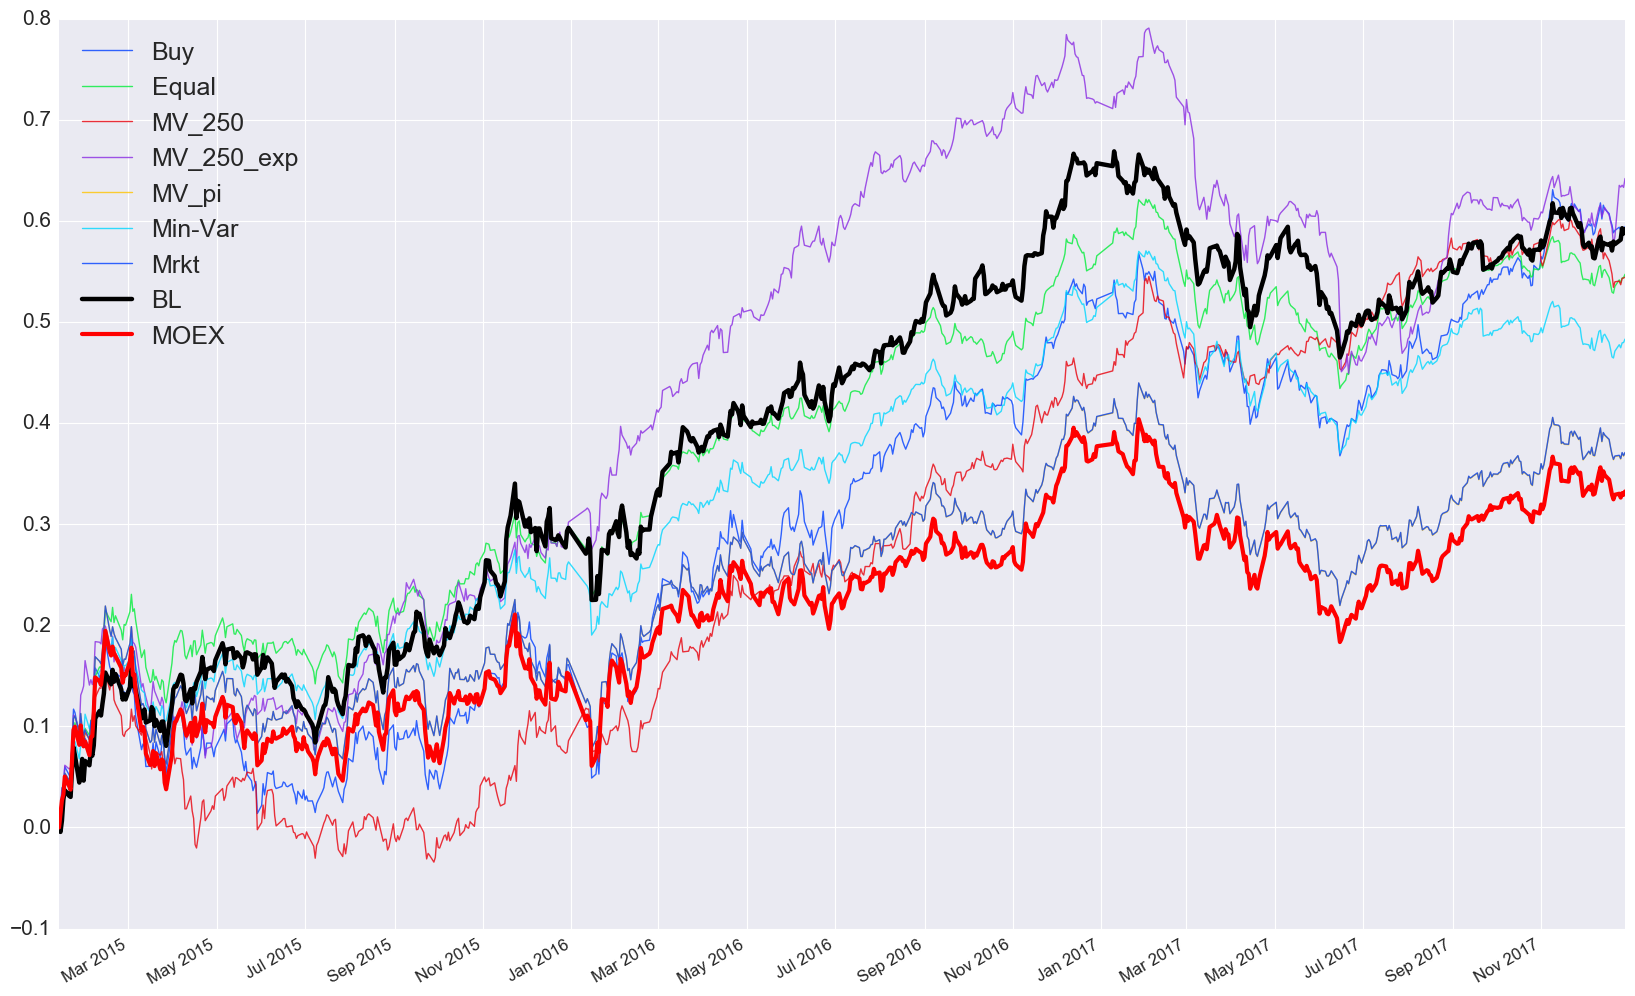

In [1441]:
ax = Cum_ret_all.loc[:, Cum_ret_all.columns.difference(['BL','MOEX'])].plot(figsize=(18, 13), color=mycolors, linewidth=1, alpha = 0.8)
ax = Cum_ret_all['BL'].plot(color='black', linewidth=3.2)
ax = Cum_ret_all['MOEX'].plot(color='red', linewidth=3)
ax.legend(loc=2, prop={'size': 18})
ax.set_xlabel('')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.savefig('/Users/ulybinaleksandr/Documents/ВШЭ/3_курс/ВКР/graduate thesis/Figures/cum_ret_all.png',
            dpi=250, bbox_inches='tight')

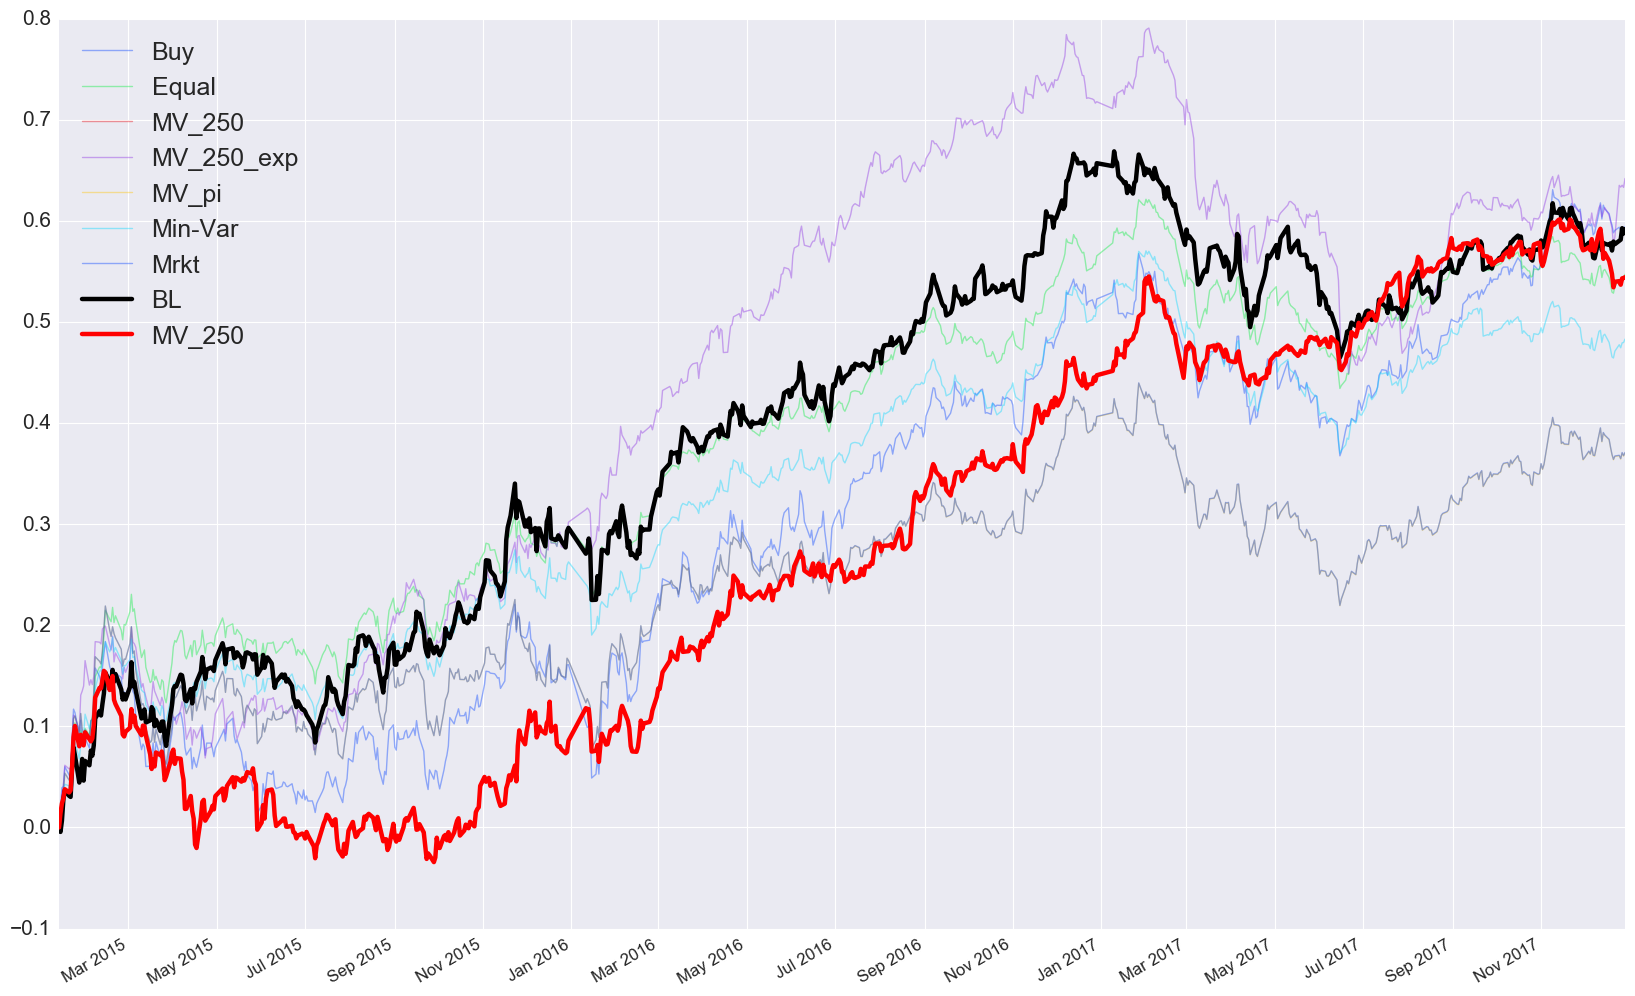

In [1443]:
ax = Cum_ret_all.loc[:, Cum_ret_all.columns.difference(['BL','MOEX'])].plot(figsize=(18, 13), color=mycolors, linewidth=1, alpha = 0.4, legend='')
ax = Cum_ret_all['BL'].plot(color='black', linewidth=3.2)
ax = Cum_ret_all['MV_250'].plot(color='red', linewidth=3.2)
ax.legend(loc=2, prop={'size': 18})
ax.set_xlabel('')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

In [1212]:
df = Cum_ret_all

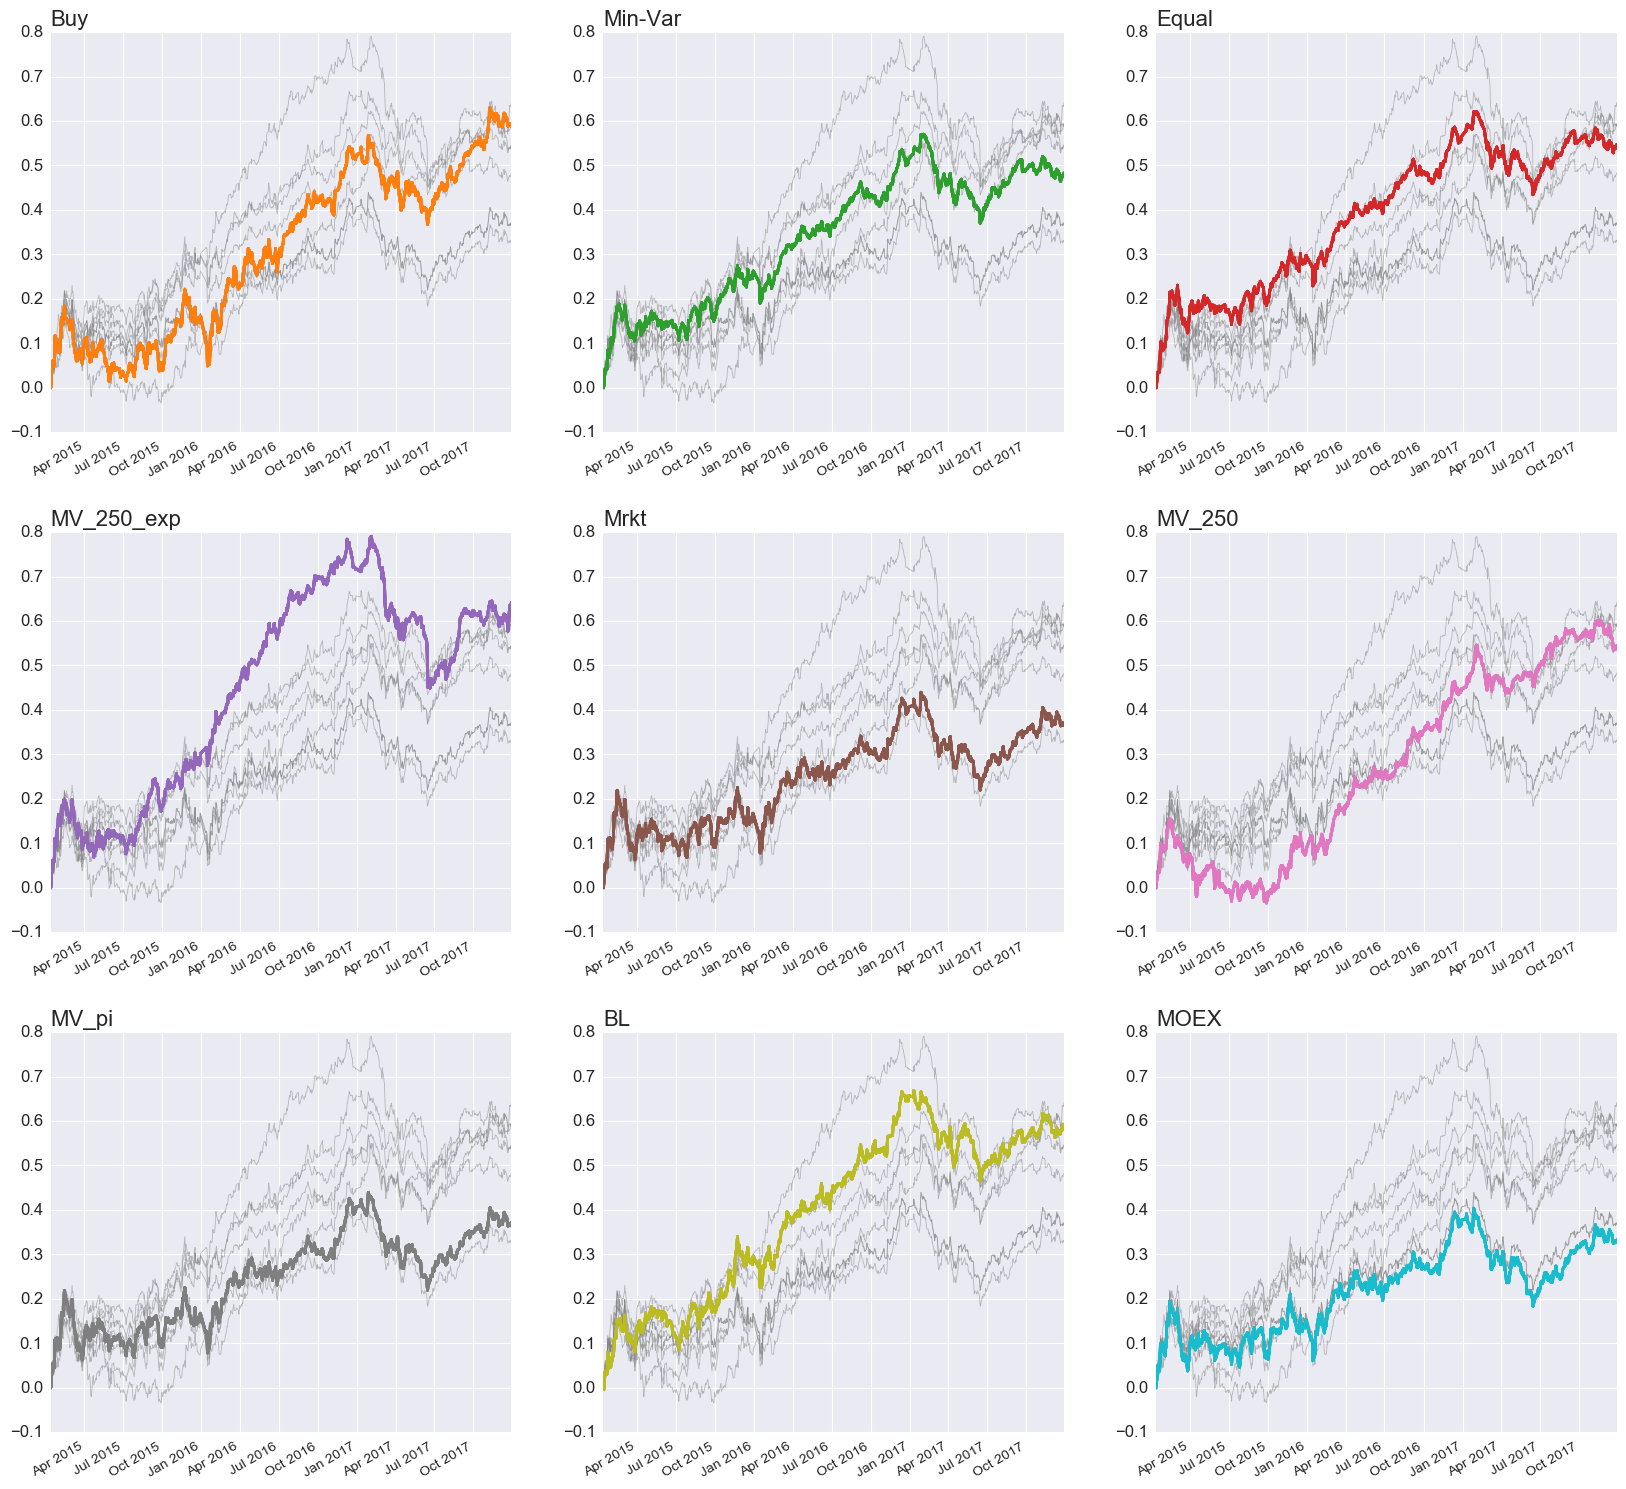

In [1213]:
df = Cum_ret_all
# Initialize the figure
plt.style.use('seaborn-darkgrid')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=12) 

# create a color palette
palette = plt.get_cmap('tab10')
plt.figure(figsize=(18, 20))

# multiple line plot
num=0
for column in df:
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(3,3, num)
    # plot every groups, but discreet
    for v in df:
        ax = df[v].plot(marker='', color='grey', linewidth=0.6, alpha=0.5)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.set_xlabel('')
 
    # Plot the lineplot
        ax = df[column].plot(marker='', color=palette(num), linewidth=2, alpha=0.9, label=column)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.set_xlabel('')
 
    # Add title
    plt.title(column, loc='left', fontsize=16, fontweight=6 )
    plt.subplots_adjust(hspace=0.25)

    plt.savefig('/Users/ulybinaleksandr/Documents/ВШЭ/3_курс/ВКР/graduate thesis/Figures/cum_ret_sep.png',
            dpi=250, bbox_inches='tight')

## Сделаем дневную доходность

In [1214]:
Daily_rets = []
strats = []
for key, val in prtf_results.items():
    Daily_rets.append(prtf_results[key]['Daily_ret'].flatten())
    strats.append(key)

In [1215]:
Daily_ret_all = pd.DataFrame(np.array(Daily_rets).T, 
                           columns = strats)
Daily_ret_all['MOEX'] = pd.Series(moex_log_ret)
Daily_ret_all.index = caps.index

## Trailing Sharpe

In [1228]:
trailing_sr_all = []
for col in Daily_ret_all.columns:
    trailing_sr = []
    for i in range(0, len(test_dates)-252):
        df = Daily_ret_all.iloc[1:, :].iloc[i:252+i, :][col]
        rf_subset = rf_test[1:][i:252+i].flatten()
        trailing_sr.append(get_SR(np.array(df), rf_subset))
    trailing_sr_all.append(trailing_sr) 

In [1229]:
SR_all = pd.DataFrame(np.array(trailing_sr_all).T, columns=Daily_ret_all.columns, index=Daily_ret_all.index[252:])

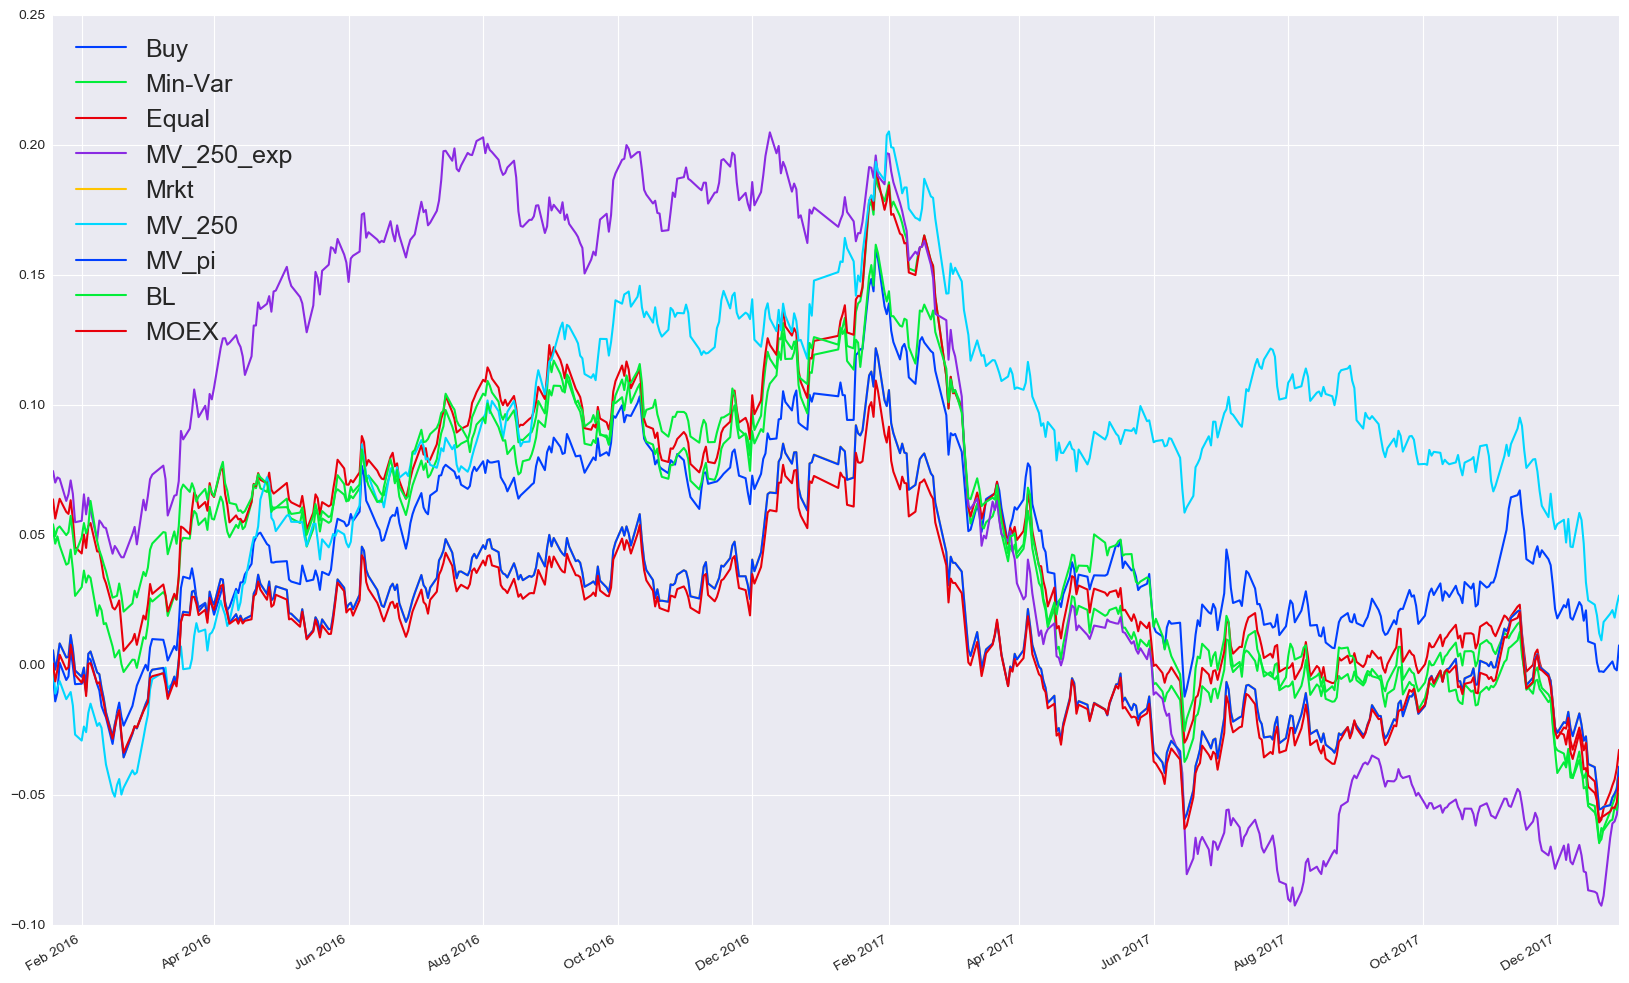

In [1230]:
ax = SR_all.plot(figsize=(18, 13), color=mycolors, linewidth=1.5)
ax.legend(loc=2, prop={'size': 18})
ax.set_xlabel('')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

In [ ]:
ax = Cum_ret_all.plot(figsize=(18, 13), color=mycolors, linewidth=1, alpha = 0.4)
ax = Cum_ret_all['BL'].plot(color='black', linewidth=3.2)
ax = Cum_ret_all['MV_250'].plot(color='red', linewidth=3.2)
ax.legend(loc=2, prop={'size': 18})
ax.set_xlabel('')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

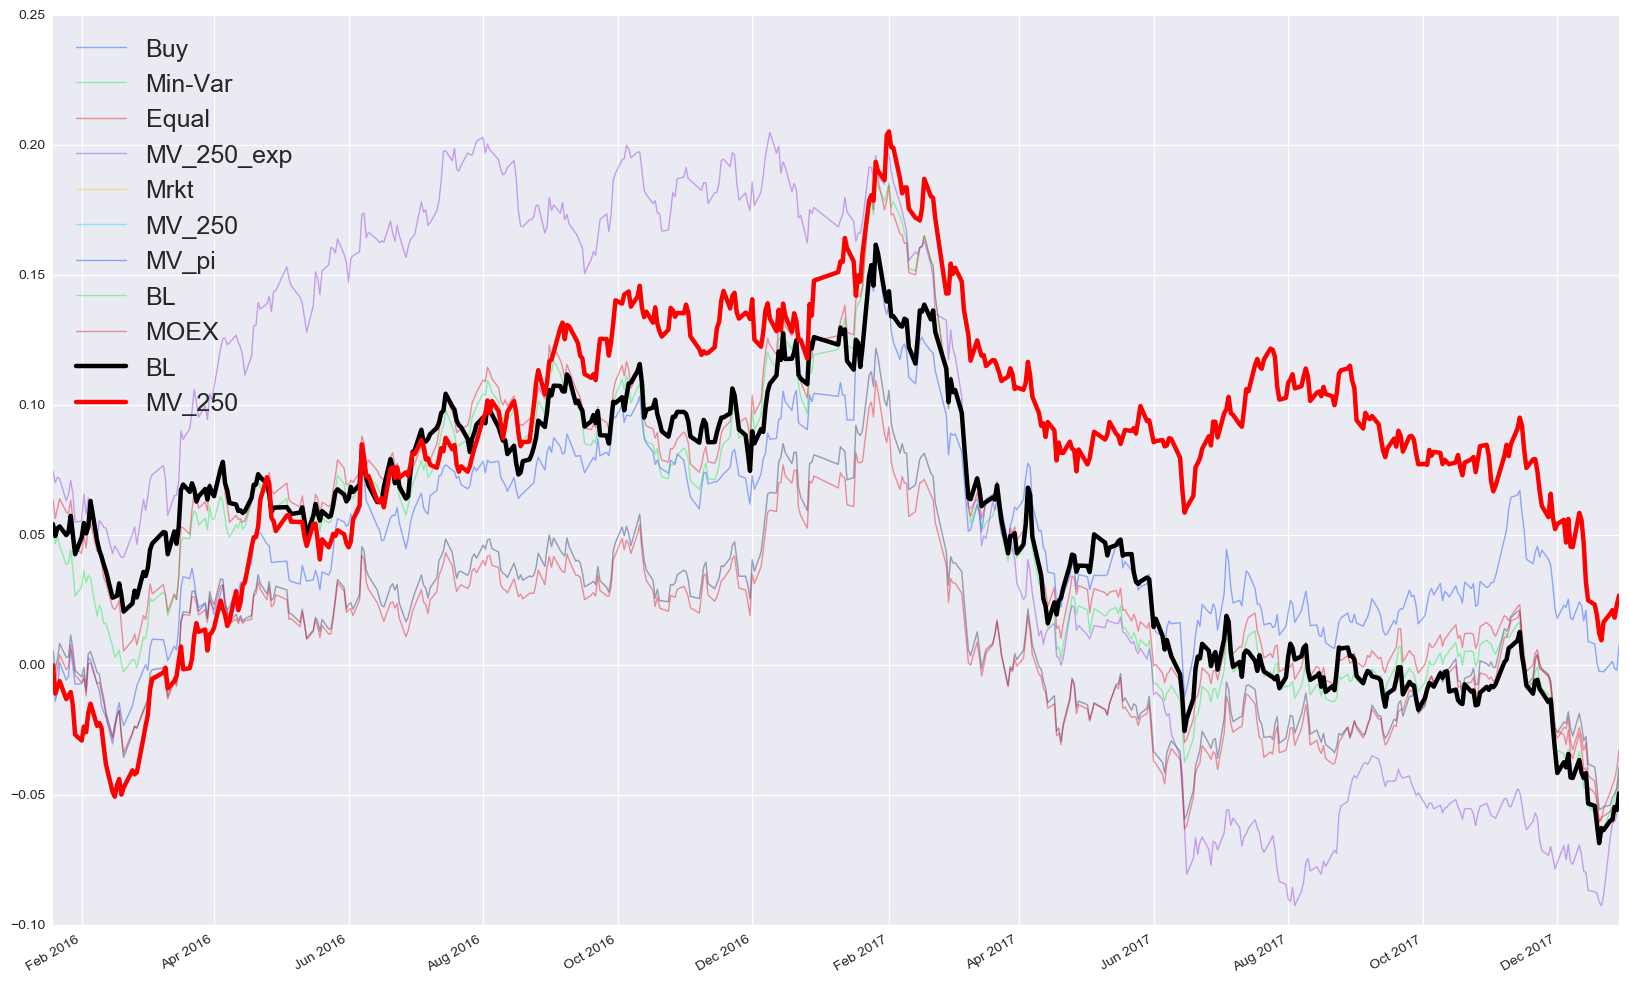

In [1231]:
ax = SR_all.plot(figsize=(18, 13), color=mycolors, linewidth=1, alpha = 0.4)
ax = SR_all['BL'].plot(color='black', linewidth=3.2)
ax = SR_all['MV_250'].plot(color='red', linewidth=3.2)
ax.legend(loc=2, prop={'size': 18})
ax.set_xlabel('')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

## Статистика по Шарпу

In [1180]:
rfr = rf_test[1:]

In [1420]:
# функции для статистического теста SR

def get_kurt(x):
    n=len(x)
    x4 = np.sum(np.power(x, 4))
    x3 = np.sum(np.power(x, 3))
    x2 = np.sum(np.power(x, 2))
    x1 = np.sum(x)
    A = (n**3+n**2)*x4-4*(n**2+n)*x3*x1-3*(n**2-n)*(x2**2)+12*n*x2*(x1**2)-6*(x1**4)
    B = (np.var(x, ddof=1)**2)*n*(n-1)*(n-2)*(n-3)
    kurt = 3*(n-1)/(n+1)+(n-2)*(n-3)/((n+1)*(n-1))*A/B
    return kurt

def get_skew(x):
    n=len(x)
    x3 = np.sum(np.power(x, 3))
    x2 = np.sum(np.power(x, 2))
    x1 = np.sum(x)
    A = n*x3-3*x1*x2+2*(x1**3)/n
    B = (np.sqrt(np.var(x, ddof=1))**3)*(n-1)*(n-2)
    skew = (n-2)/np.sqrt(n*(n-1))*A/B
    return skew

def get_m22(a, b):
    n=len(a)
    a2 = np.sum(np.power(a, 2))
    a1 = np.sum(a)
    b2 = np.sum(np.power(b, 2))
    b1 = np.sum(b)
    ab = np.sum(a*b)
    ab2 = np.sum(a*np.power(b,2))
    a2b = np.sum(np.power(a,2)*b)
    a2b2 = np.sum(np.power(a,2)*np.power(b,2))
    A = -3*(a1**2)*(b1**2)+n*b2*(a1**2)  +  4*n*a1*b1*ab-2*(2*n-3)*ab**2-2*(n**2-2*n+3)*a1*ab2 + \
            (b1**2)*a2-(2*n-3)*b2*a2 -2*(n**2-2*n+3)*b1*a2b+n*(n**2-2*n+3)*a2b2
    B = (n-3)*(n-2)*(n-1)*n
    m22 = A/B
    return m22

def get_m12(a, b):
    n=len(a)
    a2 = np.sum(np.power(a, 2))
    a1 = np.sum(a)
    b2 = np.sum(np.power(b, 2))
    b1 = np.sum(b)
    ab = np.sum(a*b)
    ab2 = np.sum(a*np.power(b,2))
    a2b = np.sum(np.power(a,2)*b)
    a2b2 = np.sum(np.power(a,2)*np.power(b,2))
    A = 2*(b1**2)*a1-n*b2*a1-2*b1*ab+(n**2)*ab2
    B = (n-2)*(n-1)*n
    m12 = A/B
    return m12

def get_m21(a, b):
    n=len(a)
    a2 = np.sum(np.power(a, 2))
    a1 = np.sum(a)
    b2 = np.sum(np.power(b, 2))
    b1 = np.sum(b)
    ab = np.sum(a*b)
    ab2 = np.sum(a*np.power(b,2))
    a2b = np.sum(np.power(a,2)*b)
    a2b2 = np.sum(np.power(a,2)*np.power(b,2))
    A = 2*(a1**2)*b1-n*a2*b1-2*a1*ab+(n**2)*a2b
    B = (n-2)*(n-1)*n
    m21 = A/B
    return m21

def get_var_diff(a, b, rfr):
    from scipy.stats.stats import pearsonr  
    SRa = get_SR(a, rfr)
    SRb = get_SR(b, rfr)
    kurtA = get_kurt(a)
    kurtB = get_kurt(b)
    skewA = get_skew(a)
    skewB = get_skew(b)
    m22 = get_m22(a,b)
    m12 = get_m12(a, b)
    m21 = get_m21(a, b)
    n= len(a)
    A = (1+(SRa**2/4)*(kurtA-1)-SRa*skewA)
    B = (1+(SRb**2/4)*(kurtB-1)-SRb*skewB)
    C = pearsonr(a, b)[0][0]+ (SRa*SRb/4)*(m22/(np.var(a, ddof=1)*np.var(b, ddof=1))-1) 
    D = -0.5*SRa*m21/(np.std(b, ddof=1)*np.var(a, ddof=1)) -0.5*SRb*m12/(np.std(a, ddof=1)*np.var(b, ddof=1)) 
    Var_diff = np.sqrt((A+B-2*(C+D))/(n-1))
    return Var_diff

def SR_unbiased(x, rfr):
    SR = get_SR(x, np.mean(rfr))
    kurt = get_kurt(x)
    return SR/(1+0.25*(kurt-1)/len(x))

def SR_std(x, rfr):
    SR_x = get_SR(x, rfr)
    kurt = get_kurt(x)
    skew = get_skew(x)
    n = len(x)
    STD_x = np.sqrt((1+((SR_x**2)/4)*(kurt-1)-SR_x*skew)/(n-1)) 
    return STD_x

def SR_z_crit(x, rfr, twotail = True):
    from scipy.stats import norm
    # H0: SR = 0
    # twotail=False  H1: SR<0
    # twotail=True  H1: SR <> 0
    STD = SR_std(x, rfr)
    SR_unb = SR_unbiased(x, rfr)
    z = SR_unb/STD
    if twotail:
        pval = norm.cdf(z)*2 if (1 - norm.cdf(z) >= 0.5) else (1 - norm.cdf(z))*2
    else: 
        pval = (1 - norm.cdf(z))
    return pval

def SR_z_crit_diff(a, b, rfr, twotail = True):
    from scipy.stats import norm
    # H0: SRb - SRa = 0
    # twotail=False  H1: SRb-SRa <= 0
    # twotail=True  H1: SRb-SRa <> 0
    SRa_unb = SR_unbiased(a, rfr)
    SRb_unb = SR_unbiased(b, rfr)
    STD = get_var_diff(a, b, rfr)
    z = np.abs(SRb_unb - SRa_unb)/STD
    if twotail:
        pval = norm.cdf(z)*2 if (1 - norm.cdf(z) >= 0.5) else (1 - norm.cdf(z))*2
    else: 
        pval = (1 - norm.cdf(z))
    return pval

In [1222]:
year15 = Daily_ret_all.loc[pd.Timestamp('2015-01-13'):pd.Timestamp('2015-12-31'), :]
year16 = Daily_ret_all.loc[pd.Timestamp('2016-01-01'):pd.Timestamp('2016-12-31'), :]
year17 = Daily_ret_all.loc[pd.Timestamp('2017-01-01'):pd.Timestamp('2017-12-31'), :]

In [1414]:
def pval_matrix(df):
    pvals = np.zeros(( df.shape[1], df.shape[1]))

    for i in range(df.shape[1]):
        for j in range(df.shape[1]):
            pvals[i, j] = SR_z_crit(np.array(df.iloc[:, i])[:, np.newaxis], np.mean(rfr)) if i==j else \
            SR_z_crit_diff(np.array(df.iloc[:, i])[:, np.newaxis], np.array(df.iloc[:, j])[:, np.newaxis], np.mean(rfr))
    return pd.DataFrame(pvals, index=df.columns, columns = df.columns)

### Весь период

In [1235]:
# matplotlib.rc('xtick', labelsize=10) 
# matplotlib.rc('ytick', labelsize=10) 
# plt.figure(figsize=(6, 6))
# ax = sns.heatmap(pval_matrix(Daily_ret_all.iloc[1:, :]), annot=True, fmt=".2f", linewidths=.5, cmap="PuBu", alpha = 0.7)

In [1422]:
pval_matrix(Daily_ret_all.iloc[1:, :]).to_csv('pval_tot.csv')

In [1423]:
pval_matrix(Daily_ret_all.iloc[1:, :]).to_csv('pval_tot.csv')
pval_matrix(year15).to_csv('pval_15.csv')
pval_matrix(year16).to_csv('pval_16.csv')
pval_matrix(year17).to_csv('pval_17.csv')

## Трансакционные издержки 

In [1381]:
def get_tc_coef(strat_w):
    df1 = pd.DataFrame(np.zeros((1,52)), columns=Tickers_test)
    for i in range(0, len(strat_w)):
        df4 = pd.DataFrame(strat_w[i][:, np.newaxis].T,  columns=daly_Tickers[i])
        df1 = df1.append(df4)
    df1 = df1[1:].fillna(0)
    df1.index = bidaskspread.index
    
    # df1 = df1[1:].fillna(0).diff()
    # df1.index = bidaskspread.index
    # df1 = df1.fillna(0)
    #1- np.sum(np.abs(df1)*transac_cost, axis=1)
    cost_pct = np.ones((len(test_dates),1))

    for i, day in enumerate(test_dates[1:], start=1):
        log_ret = log_ret_test.loc[day, :].fillna(0)
        bd_prop = transac_cost.loc[day, :]
        A = (df1.iloc[i-1, :]*log_ret)
        B = (np.sum(df1.iloc[i-1, :]*log_ret))
        cost_pct[i] = 1-np.sum(np.abs(df1.iloc[i, :] - A/B)*bd_prop)        
    return cost_pct

In [1387]:
def performance_with_tc(weights, tc_coef):
    
    Equity_mm_log = np.ones((len(test_dates),1))
    P_ret_log = np.zeros((len(test_dates),1))
    Cum_log = np.zeros((len(test_dates),1))

    for i, day in enumerate(test_dates[1:], start=1):
        log_ret = log_ret_test.loc[day, daly_Tickers[i-1]]
        
        # Log доходность 
        Equity_mm_log[i] = np.sum(weights[i-1]*Equity_mm_log[i-1]*log_ret)*tc_coef[i]
        P_ret_log[i] = np.log(np.sum(weights[i-1]*log_ret)*tc_coef[i])
        Cum_log[i] = np.sum(P_ret_log) 
    
    return Equity_mm_log, P_ret_log, Cum_log

### Посчитаем коэффициенты транзакционных издержек портфелей

In [1424]:
prtf_results_tc = {} 
prtf_names = ['Min-Var', 'Equal', 'MV_pi', 'MV_250_exp', 'MV_250', 'BL', 'Mrkt', 'Buy']
             
for i, prtf in enumerate([d_w_minVar, d_w_equal, d_w_MV_pi, d_w_MV_250_exp, d_w_MV_250, d_w_BL, 
                                                                                  d_w_mrkt, d_w_buy]):
    prtf_results_tc[prtf_names[i]] = {'Costs': get_tc_coef(prtf)}

In [1427]:
Etc, Ptc, Ctc = performance_with_tc(d_w_BL, prtf_results_tc['BL']['Costs'])

### Посчитаем чистую доходность 

In [1435]:
for i, prtf in enumerate([d_w_minVar, d_w_equal, d_w_MV_pi, d_w_MV_250_exp, d_w_MV_250, d_w_BL, 
                                                                                  d_w_mrkt, d_w_buy]):
    Equity, Daily_ret, Cum_ret = performance_with_tc(d_w_BL, prtf_results_tc[prtf_names[i]]['Costs'])
    prtf_results_tc[prtf_names[i]].update({'Equity': Equity, 'Daily_ret': Daily_ret, 'Cum_ret': Cum_ret})

### Чистая кумулятивная доходность 

In [1444]:
Cum_rets_net = []
strats_net = []
for key, val in prtf_results_tc.items():
    Cum_rets_net.append(prtf_results_tc[key]['Cum_ret'].flatten())
    strats_net.append(key)

In [1445]:
Cum_ret_all_net = pd.DataFrame(np.array(Cum_rets_net).T, columns = strats_net)
Cum_ret_all_net['MOEX'] = pd.Series(moex_log_cum_ret)
Cum_ret_all_net.index = caps.index

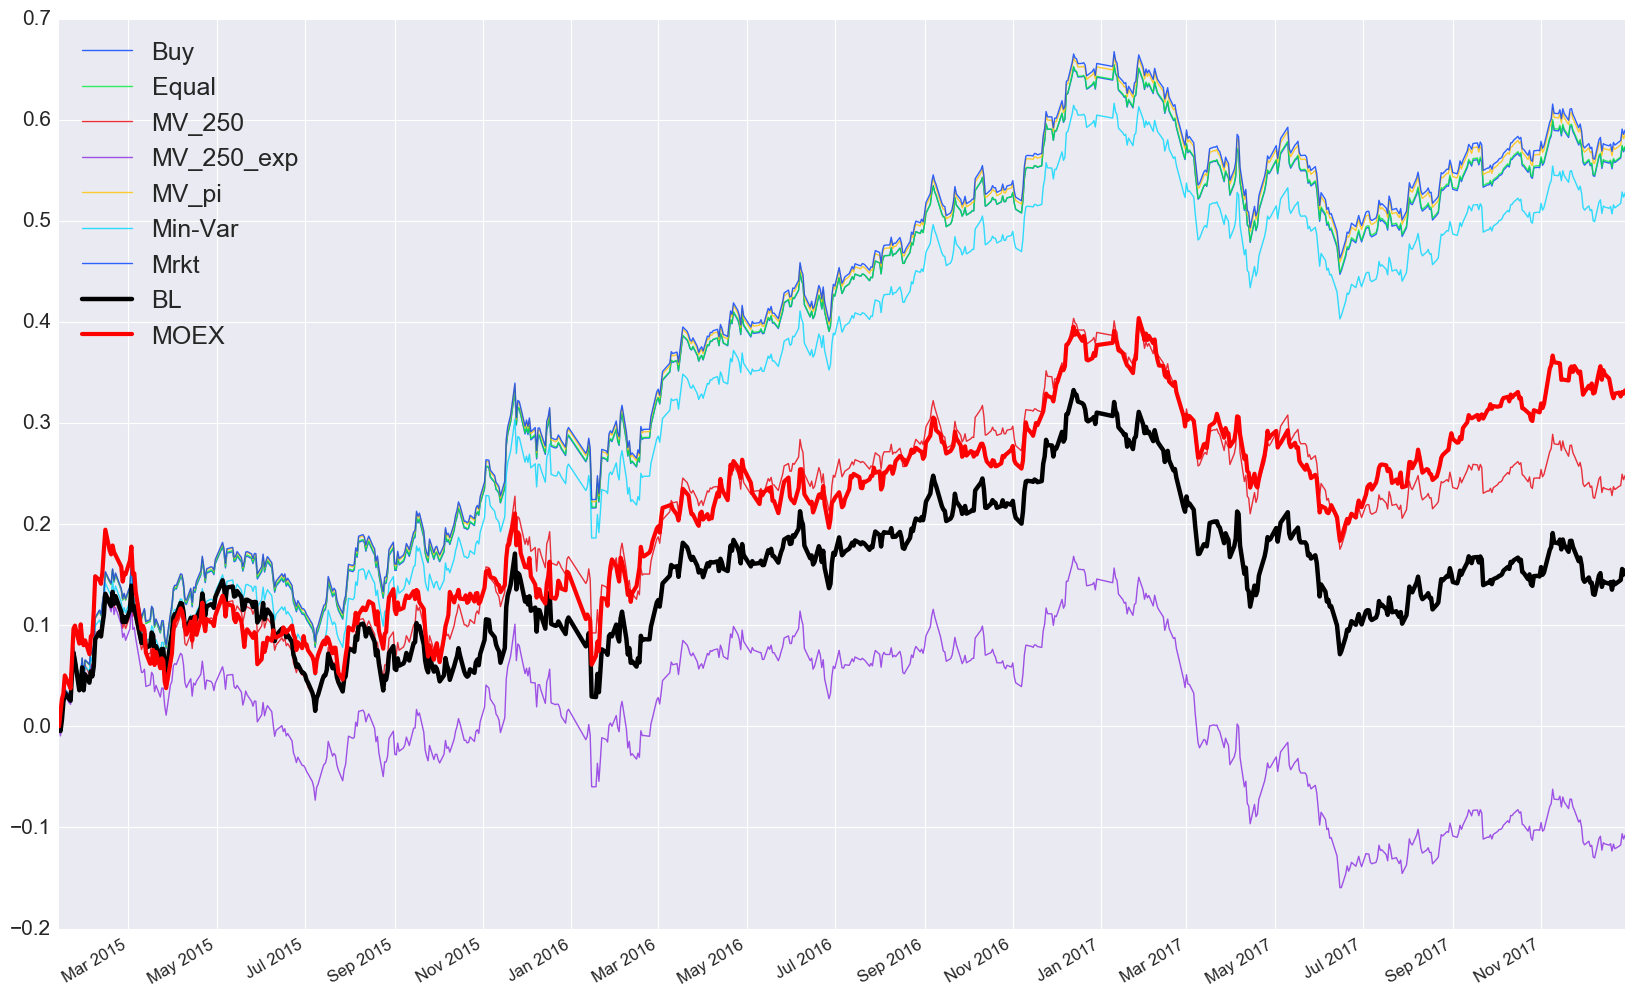

In [1446]:
ax = Cum_ret_all_net.loc[:, Cum_ret_all_net.columns.difference(['BL','MOEX'])].plot(figsize=(18, 13), color=mycolors, linewidth=1, alpha = 0.8)
ax = Cum_ret_all_net['BL'].plot(color='black', linewidth=3.2)
ax = Cum_ret_all_net['MOEX'].plot(color='red', linewidth=3)
ax.legend(loc=2, prop={'size': 18})
ax.set_xlabel('')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
#plt.savefig('/Users/ulybinaleksandr/Documents/ВШЭ/3_курс/ВКР/graduate thesis/Figures/cum_ret_all.png',
#            dpi=250, bbox_inches='tight')

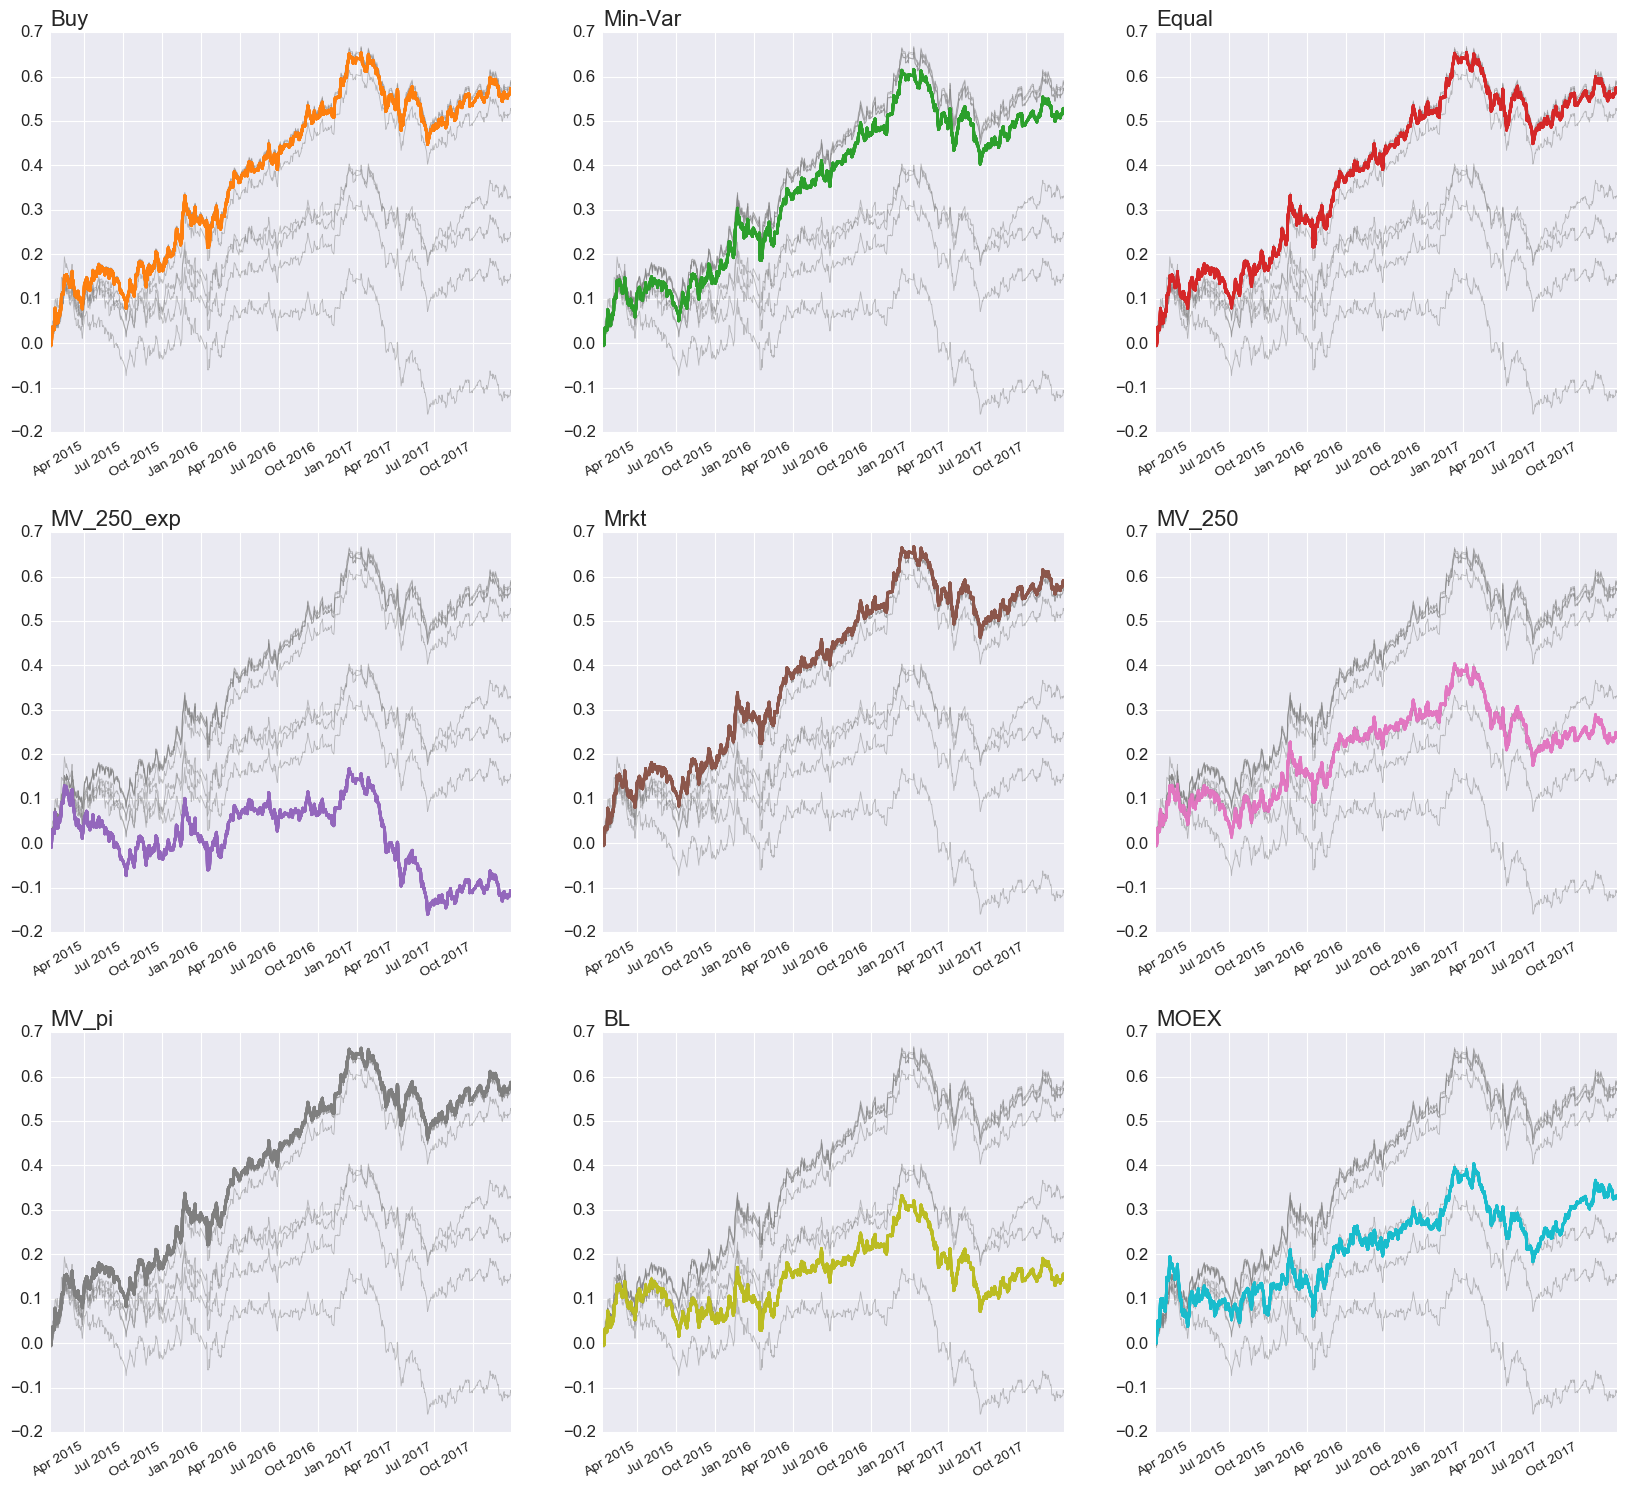

In [1447]:
df = Cum_ret_all_net
# Initialize the figure
plt.style.use('seaborn-darkgrid')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=12) 

# create a color palette
palette = plt.get_cmap('tab10')
plt.figure(figsize=(18, 20))

# multiple line plot
num=0
for column in df:
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(3,3, num)
    # plot every groups, but discreet
    for v in df:
        ax = df[v].plot(marker='', color='grey', linewidth=0.6, alpha=0.5)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.set_xlabel('')
 
    # Plot the lineplot
        ax = df[column].plot(marker='', color=palette(num), linewidth=2, alpha=0.9, label=column)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.set_xlabel('')
 
    # Add title
    plt.title(column, loc='left', fontsize=16, fontweight=6 )
    plt.subplots_adjust(hspace=0.25)

    #plt.savefig('/Users/ulybinaleksandr/Documents/ВШЭ/3_курс/ВКР/graduate thesis/Figures/cum_ret_sep.png',
    #        dpi=250, bbox_inches='tight')

### Чиста дневная доходность

In [1448]:
Daily_rets_net = []
strats_net = []
for key, val in prtf_results_tc.items():
    Daily_rets_net.append(prtf_results_tc[key]['Daily_ret'].flatten())
    strats_net.append(key)

In [1449]:
Daily_ret_all_net = pd.DataFrame(np.array(Daily_rets_net).T, columns = strats_net)
Daily_ret_all_net['MOEX'] = pd.Series(moex_log_ret)
Daily_ret_all_net.index = caps.index

In [1458]:
trailing_sr_all_net = []
for col in Daily_ret_all_net.columns:
    trailing_sr_net = []
    for i in range(0, len(test_dates)-252):
        df = Daily_ret_all_net.iloc[1:, :].iloc[:252+i, :][col]
        rf_subset = rf_test[1:][:252+i].flatten()
        trailing_sr_net.append(get_SR(np.array(df), rf_subset))
    trailing_sr_all_net.append(trailing_sr_net) 

In [1459]:
SR_all_net = pd.DataFrame(np.array(trailing_sr_all_net).T, columns=Daily_ret_all_net.columns, index=Daily_ret_all_net.index[252:])

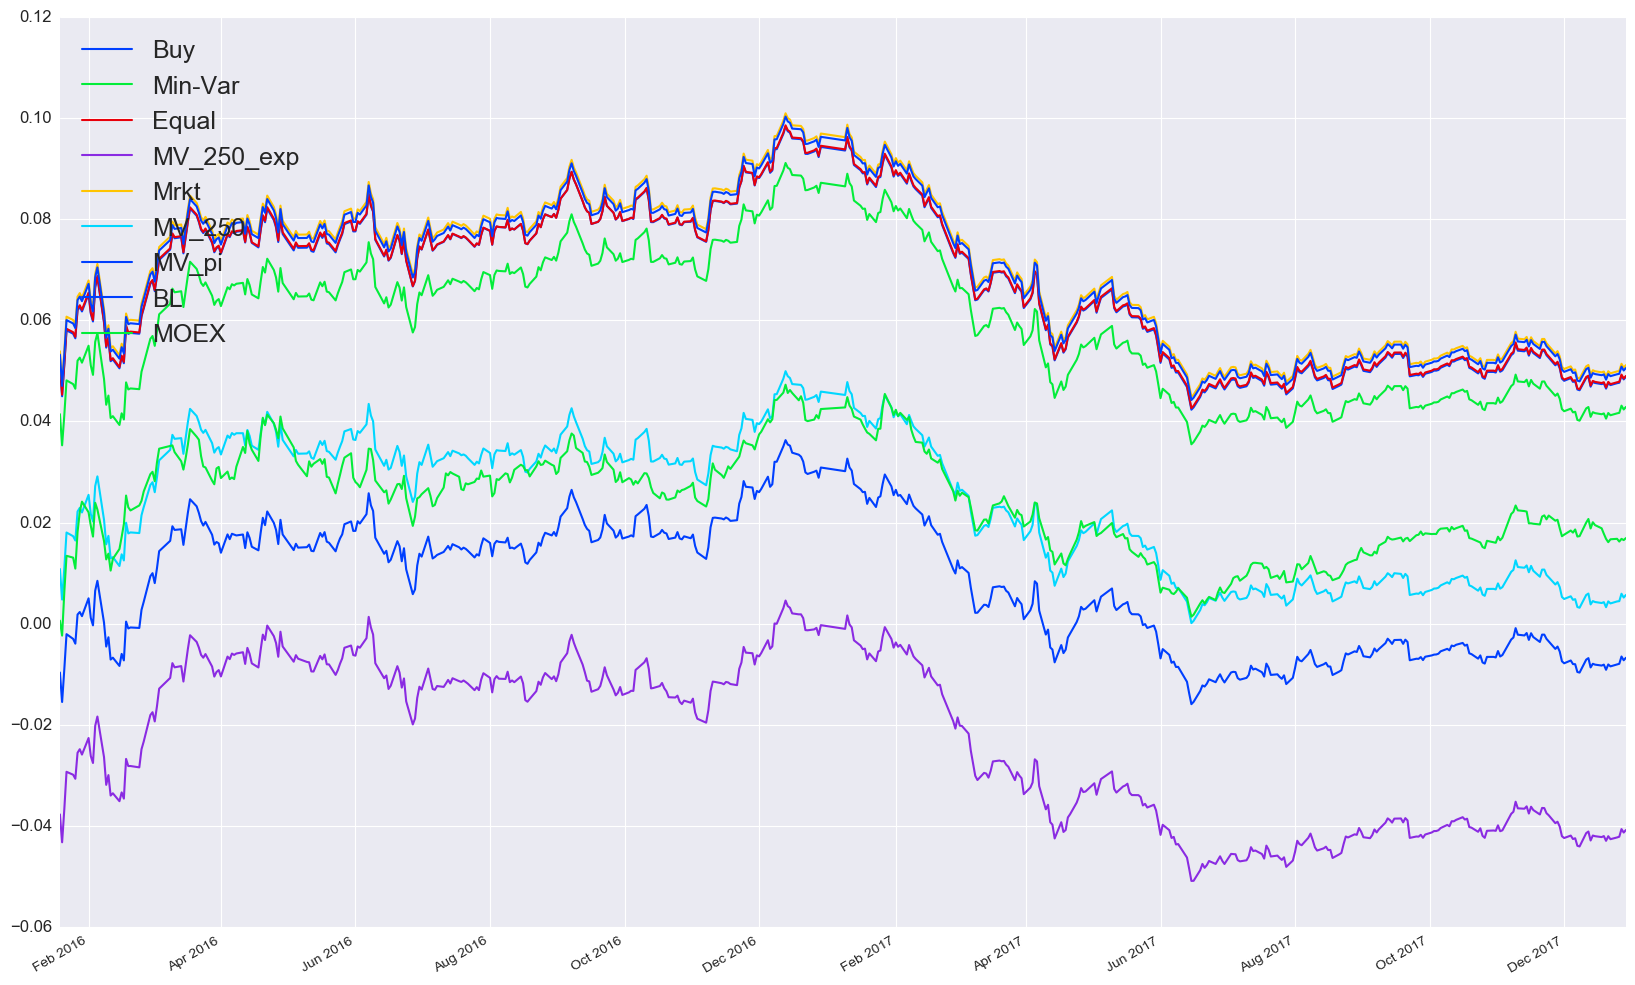

In [1460]:
ax = SR_all_net.plot(figsize=(18, 13), color=mycolors, linewidth=1.5)
ax.legend(loc=2, prop={'size': 18})
ax.set_xlabel('')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

### Проверка чистого коэффициента Шарпа 

In [1454]:
year15_net = Daily_ret_all_net.loc[pd.Timestamp('2015-01-13'):pd.Timestamp('2015-12-31'), :]
year16_net = Daily_ret_all_net.loc[pd.Timestamp('2016-01-01'):pd.Timestamp('2016-12-31'), :]
year17_net = Daily_ret_all_net.loc[pd.Timestamp('2017-01-01'):pd.Timestamp('2017-12-31'), :]

In [1457]:
pval_matrix(Daily_ret_all.iloc[1:, :])#.to_csv('pval_tot.csv')

Buy   Min-Var     Equal  MV_250_exp      Mrkt    MV_250  \
Buy         0.216356  0.948889  0.648979    0.748203  0.121445  0.882365   
Min-Var     0.948889  0.203806  0.382381    0.728407  0.132114  0.898493   
Equal       0.648977  0.382375  0.135081    0.962031  0.023467  0.883952   
MV_250_exp  0.748202  0.728406  0.962031    0.124576  0.270553  0.856931   
Mrkt        0.121447  0.132117  0.023468    0.270554  0.546400  0.393978   
MV_250      0.882364  0.898493  0.883952    0.856931  0.393977  0.167876   
MV_pi       0.120629  0.131236  0.023207    0.269814  0.982942  0.393082   
BL          0.805132  0.851566  0.843815    0.864815  0.184653  0.994834   
MOEX        0.038165  0.087719  0.015894    0.210901  0.359353  0.324342   

               MV_pi        BL      MOEX  
Buy         0.120627  0.805132  0.038164  
Min-Var     0.131234  0.851566  0.087718  
Equal       0.023205  0.843815  0.015893  
MV_250_exp  0.269813  0.864815  0.210900  
Mrkt        0.982942  0.184654  0.359353  
MV_250      0.393082  0.994834  0.324341  
MV_pi       0.547345  0.183887  0.364089  
BL          0.183886  0.165450  0.116662  
MOEX        0.364090  0.116663  0.646750

In [ ]:
pval_matrix(year15).to_csv('pval_15.csv')
pval_matrix(year16).to_csv('pval_16.csv')
pval_matrix(year17).to_csv('pval_17.csv')

### График дневной доходности - стационарность

In [1219]:
# Чтобы проверить на стационарность 
Daily_ret_all.iloc[1:, :].to_csv('Series.csv')

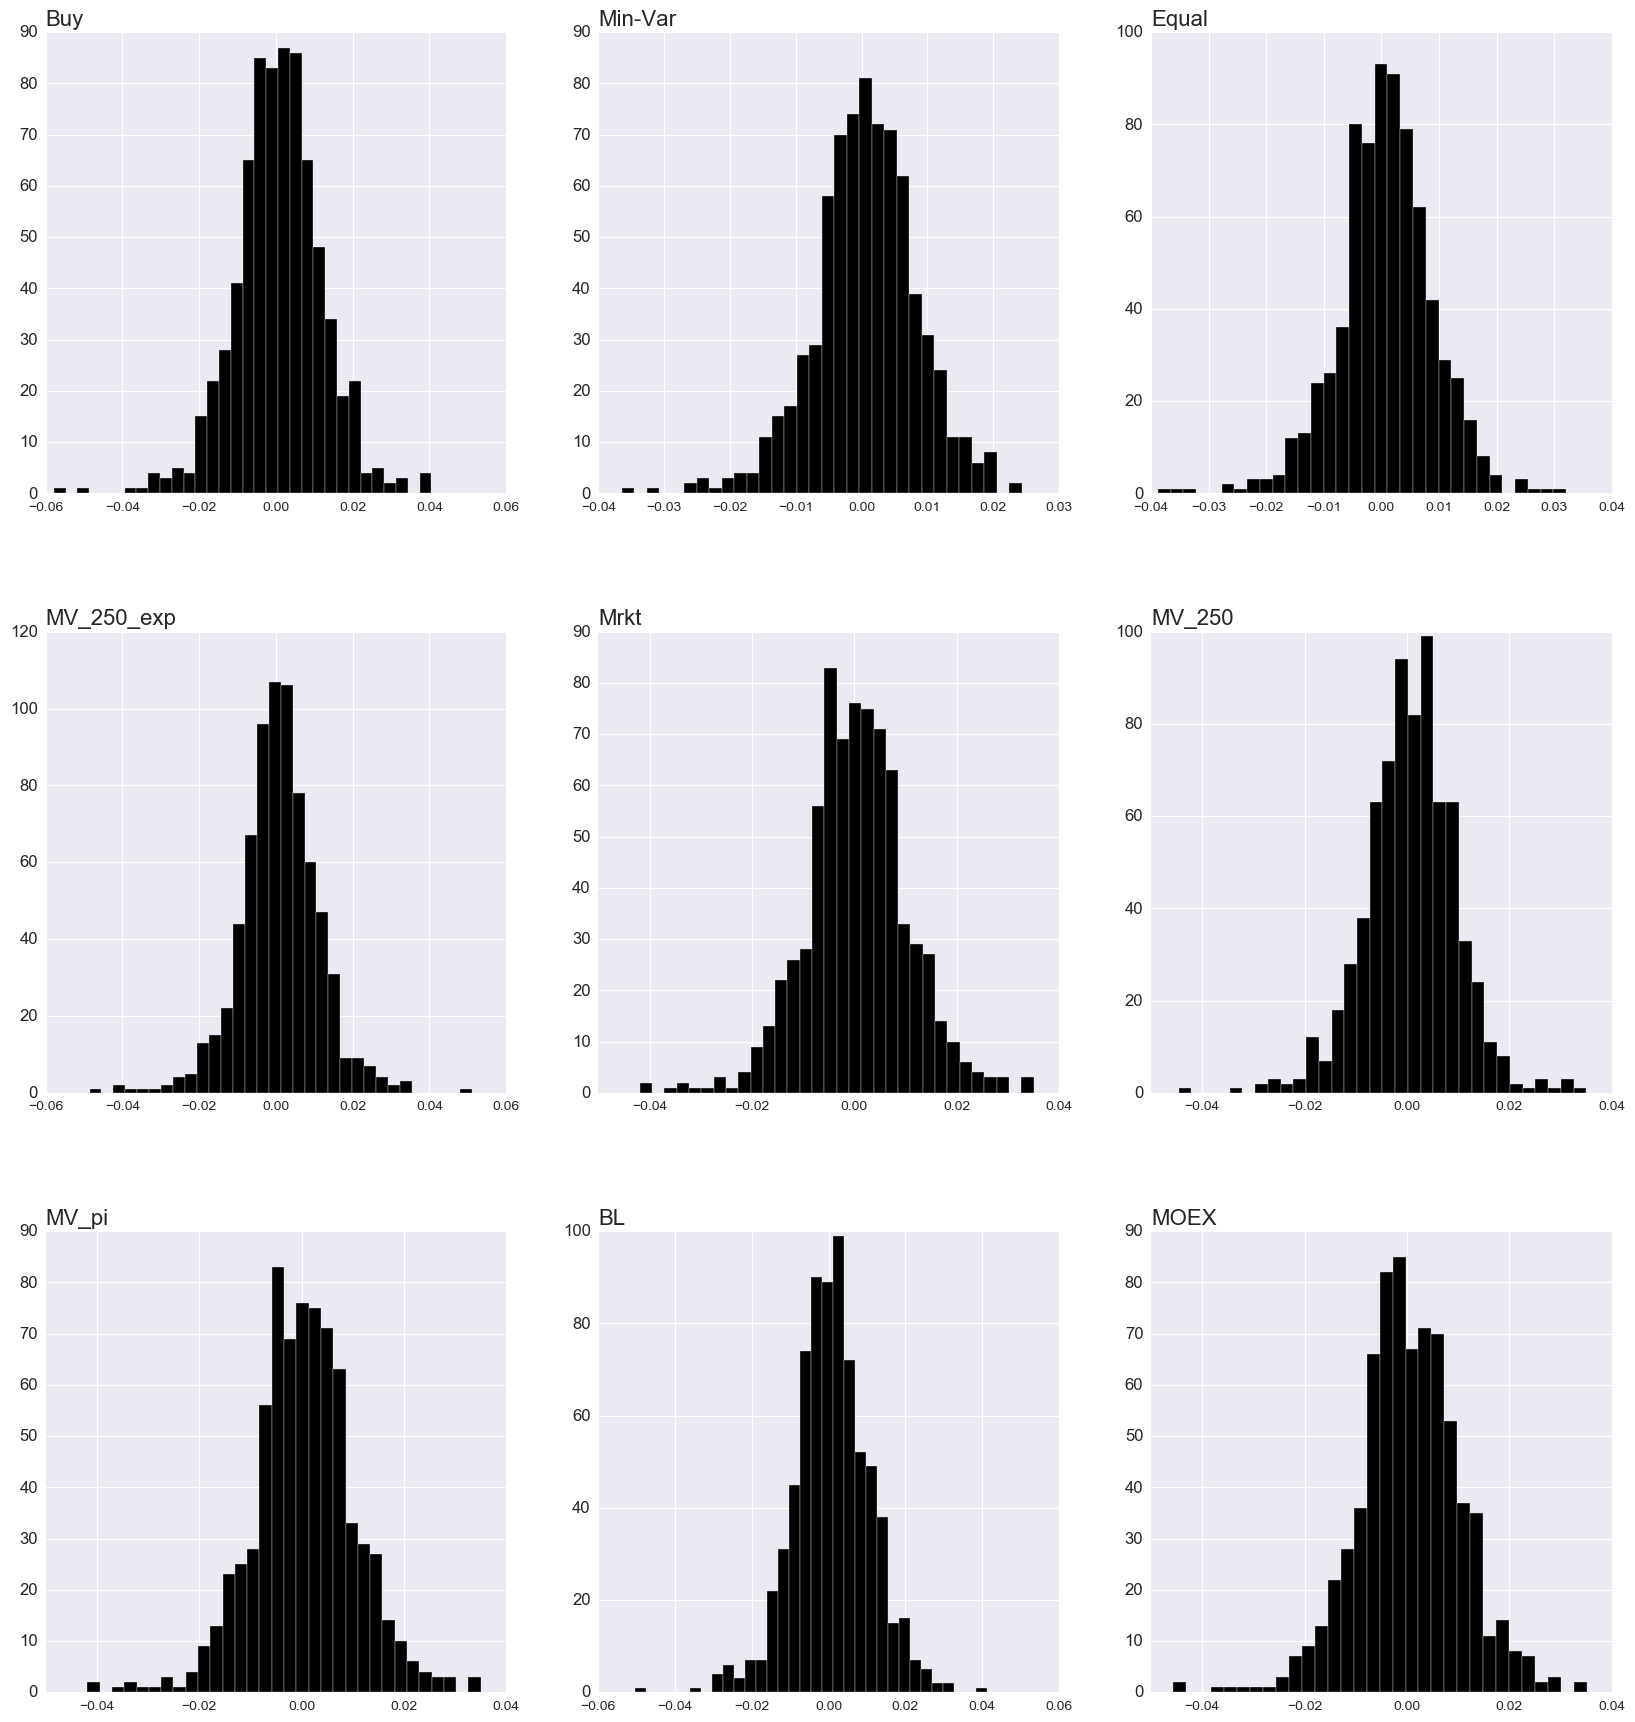

In [1220]:
df  = Daily_ret_all.iloc[1:, :]
# Initialize the figure
plt.style.use('seaborn-darkgrid')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=12) 

# create a color palette
palette = plt.get_cmap('tab10')
plt.figure(figsize=(18, 20))

# multiple line plot
num=0
for column in df:
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(3,3, num)

    # Plot the lineplot
    #ax = df[column].plot(marker='', color='black', linewidth=1, alpha=0.9, label=column)
    ax = df[column].hist(bins=32, label=column, color='black')
    #ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.set_xlabel('')
    
    # Add title
    plt.title(column, loc='left', fontsize=16, fontweight=6 )
    plt.subplots_adjust(hspace=0.3)
    plt.gcf().set_facecolor('white')
    
    plt.savefig('/Users/ulybinaleksandr/Documents/ВШЭ/3_курс/ВКР/graduate thesis/Figures/ret_hist.png',
            dpi=150, bbox_inches='tight')

## Сохранить веса в файл

In [1221]:
import pickle
filenames = ['d_w_minVar', 'd_w_equal', 'd_w_MV_pi', 'd_w_MV_250_exp', 'd_w_MV_250', 'd_w_BL', 'd_w_mrkt', 
             'd_w_buy']
# save to files
for i, prtf in enumerate([d_w_minVar, d_w_equal, d_w_MV_pi, d_w_MV_250_exp, d_w_MV_250, d_w_BL, 
                          d_w_mrkt, d_w_buy]):
    with open("optweights_final/" + filenames[i] + ".txt", "wb") as fp:   
        pickle.dump(prtf, fp)
        
# read back
#with open("Sigmas.txt", "wb") as fp:  
#    pickle.dump(Sigmas, fp)